# Pancreas Analysis


In [1]:
import sys
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/pycharm_workspace/mazebox/")
import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/Users/smgroves/Documents/anaconda3/envs/py37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Filter and concatenate

Dropkick is a tool to get rid of empty and low-quality droplets based on ambient reads. It should be applied to each sample separately, so we will apply first and then concantenate the data into one AnnData object.

In [15]:
adata = scv.datasets.pancreas()
# adata = mb.pp.scanpy_recipe(adata, retain_genes=tfs,)

In [25]:
'Nkx6-1' in adata.var_names

True

## Cell Cycle Regression

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


... storing 'phase' as categorical


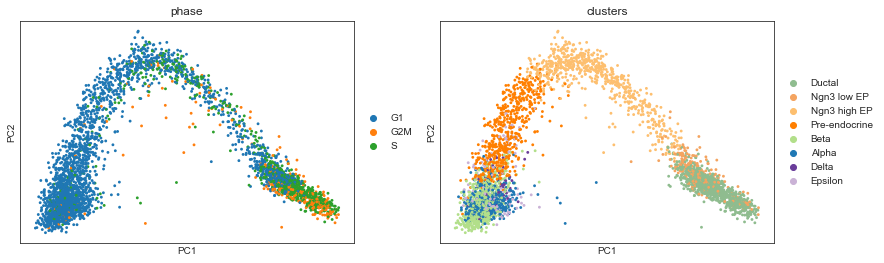

In [4]:
sc.pp.scale(adata)
scv.tl.score_genes_cell_cycle(adata)
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color=['phase','clusters'])

In [6]:
# sc.pp.regress_out(adata, ['S_score', 'G2M_score'])
# sc.pp.scale(adata)

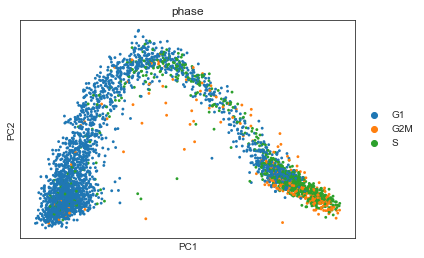

In [5]:
sc.tl.pca(adata)
sc.pl.pca_scatter(adata, color='phase')

# Dimensionality Reduction and RNA Velocity

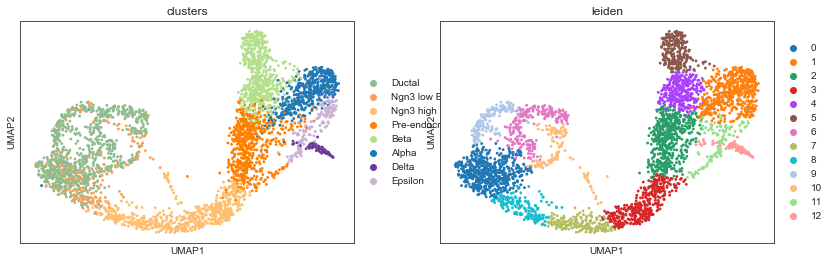

In [6]:
import matplotlib.pyplot as plt
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 1)
sc.pl.umap(adata, color = ['clusters','leiden'], ncols = 3)


## Calculating Velocity

In [7]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 8815 genes that are detected 20 counts (shared).
Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [28]:
# scv.pp.moments(adata)
scv.tl.velocity(adata, mode = 'deterministic')
scv.tl.velocity_graph(adata)



Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


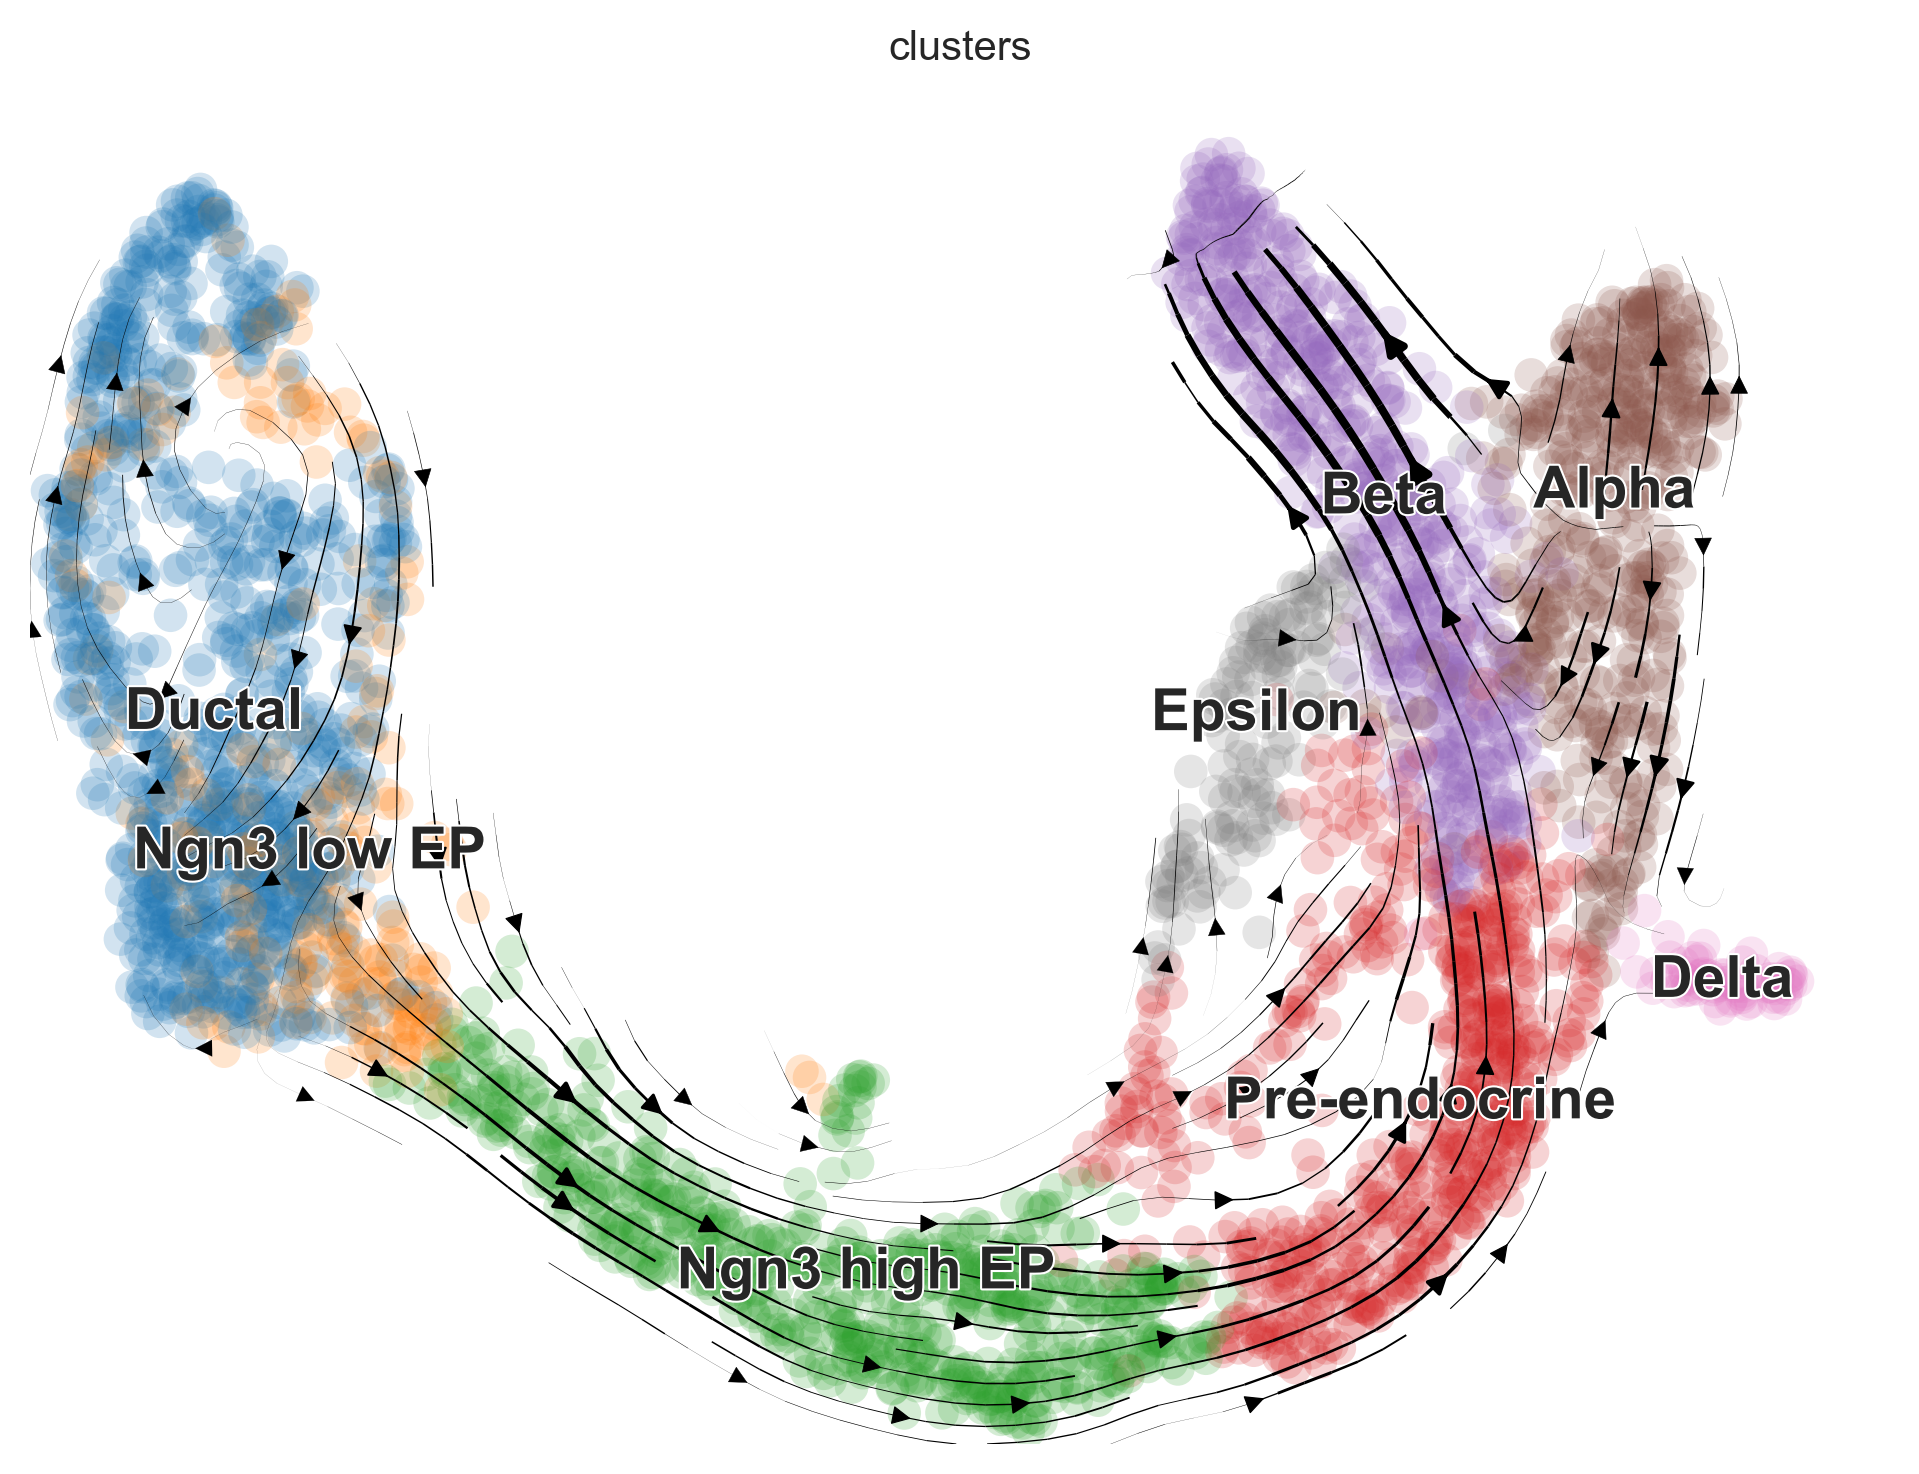

In [29]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = ['clusters'], legend_loc = 'on data',
                               figsize = (8,6), legend_fontsize=14, 
                                 dpi = 300, alpha=.2, palette='muted')


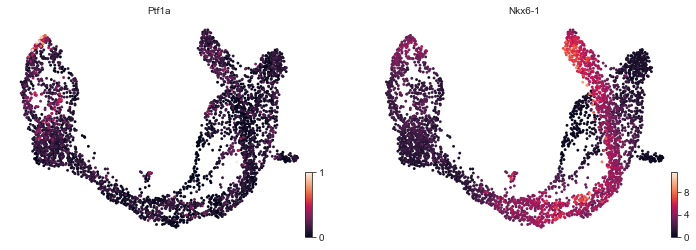

In [26]:
scv.pl.umap(adata, color = ['Ptf1a', 'Nkx6-1'], ncols = 3, smooth = True)


running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


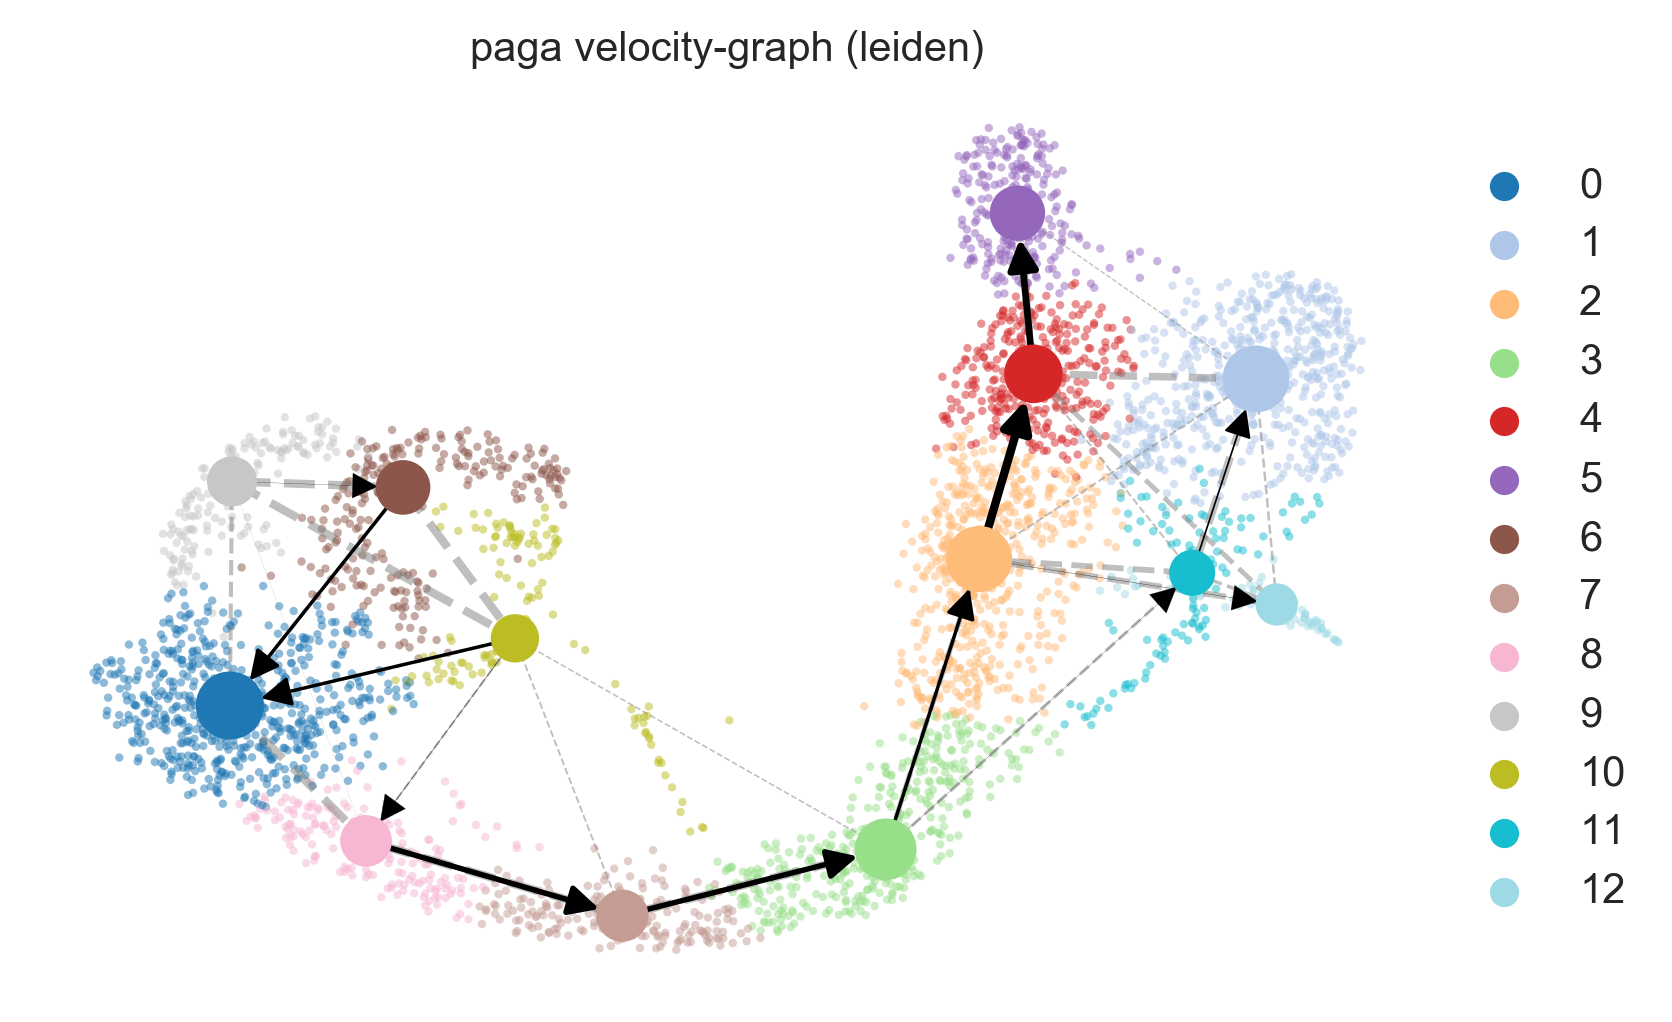

In [32]:
mb.ps.velocity_paga(adata, basis='umap')

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


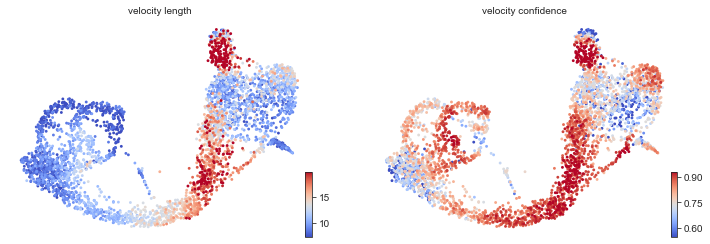

In [11]:
scv.tl.velocity_confidence(adata)

keys = 'velocity_length', 'velocity_confidence'  
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], basis = 'umap')

# Pseudotime and plasticity

We would like to see if we can get the same results as Ireland et al. did for their pseudotime analysis. To run Monocle2, we need the R interface `rpy2`. We'll also use the pseudotime inference within scvelo for comparison.

### Velocity pseudotime

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


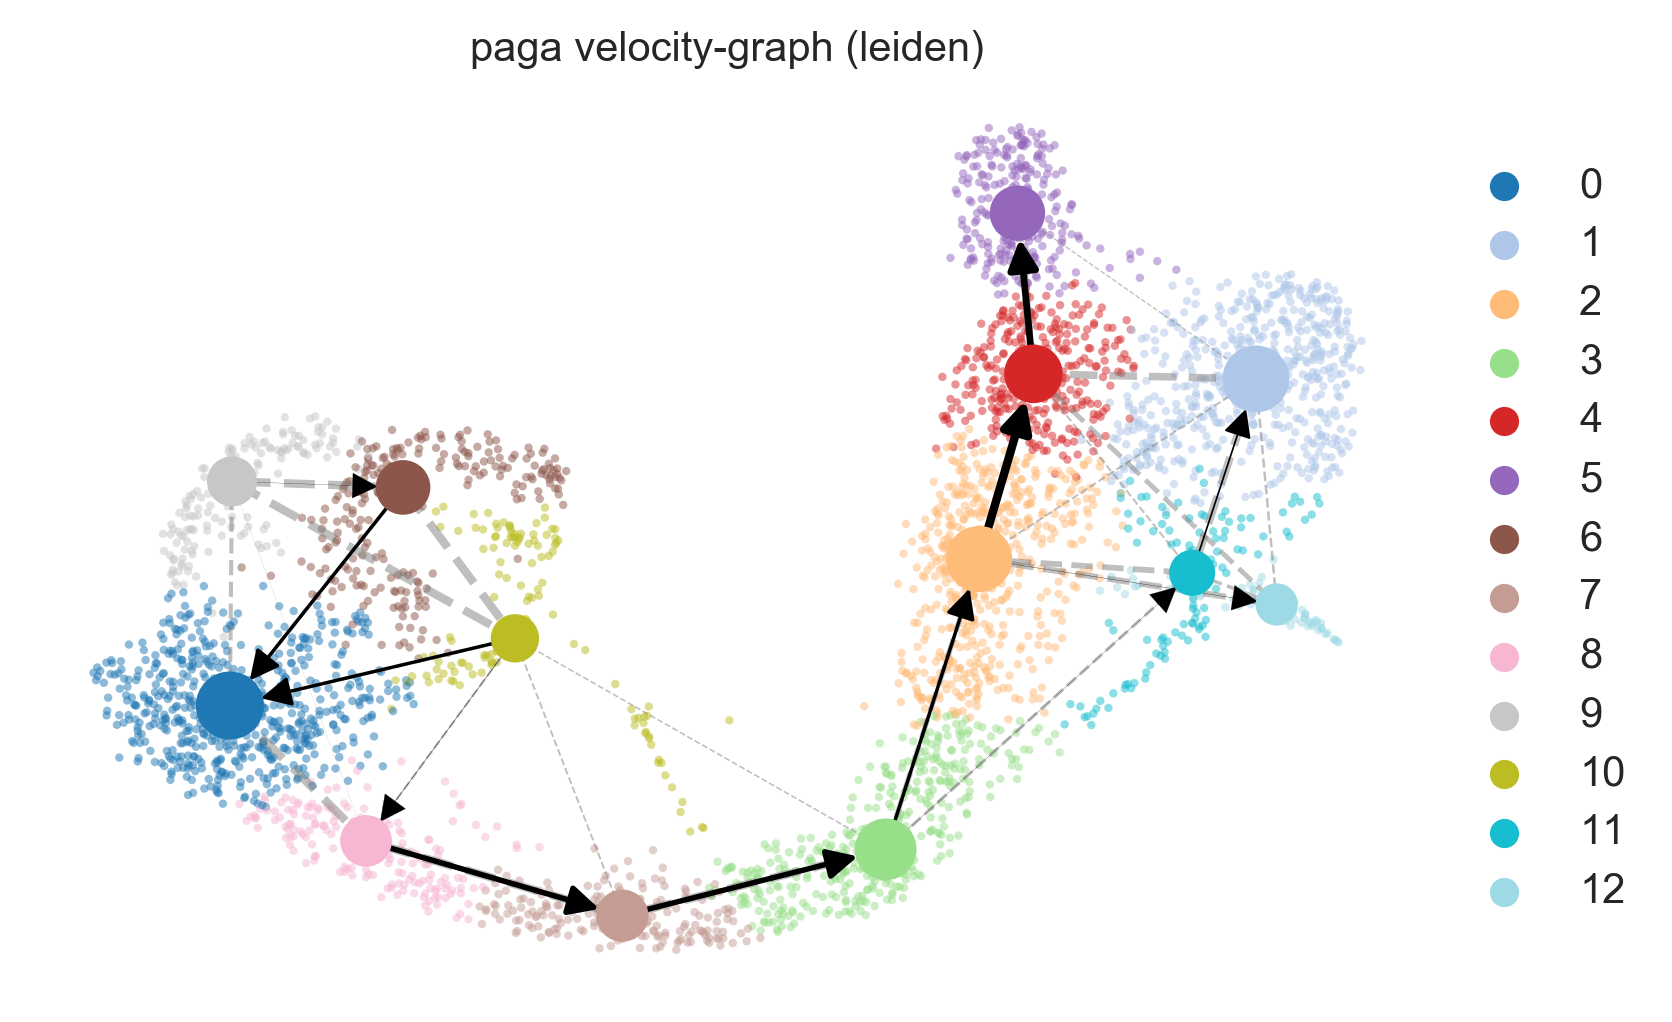

In [33]:
mb.ps.velocity_paga(adata, basis='umap')

### Calculate plasticity using CTrP

computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


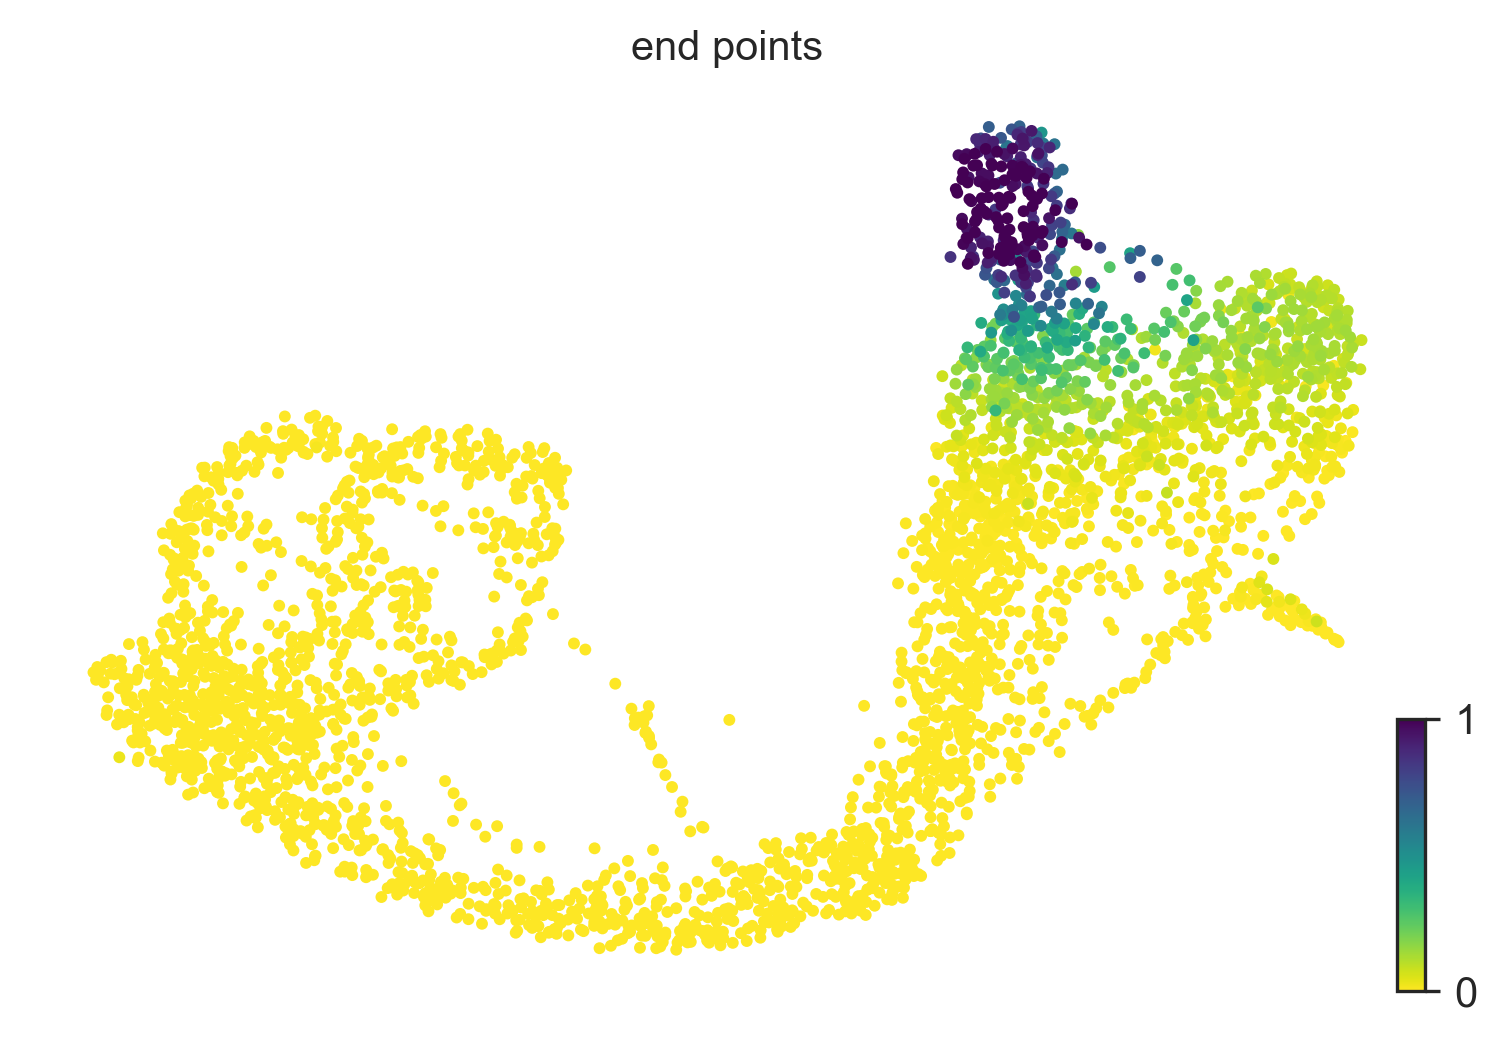

In [35]:
scv.tl.terminal_states(adata)
scv.pl.umap(adata, color = 'end_points')

In [36]:
mb.ps.ctrp_simplified(adata, distance_basis='X_pca')


Eigenvalues:  [0.99999946 0.9976367 ]
    identified 2 end points
[[0.00420609 0.01043198 0.01270948 ... 0.00030593 0.00030686 0.002007  ]
 [0.00425564 0.01048167 0.01280267 ... 0.00031179 0.00031494 0.00203509]
 [0.00455015 0.01138194 0.01281923 ... 0.00035732 0.00027431 0.00204748]
 ...
 [0.00425564 0.01048167 0.01280267 ... 0.00031179 0.00031494 0.00203509]
 [0.0049284  0.01218409 0.01265563 ... 0.00041303 0.00025061 0.00211349]
 [0.00462613 0.01159575 0.01274557 ... 0.00037171 0.00027697 0.00209219]]


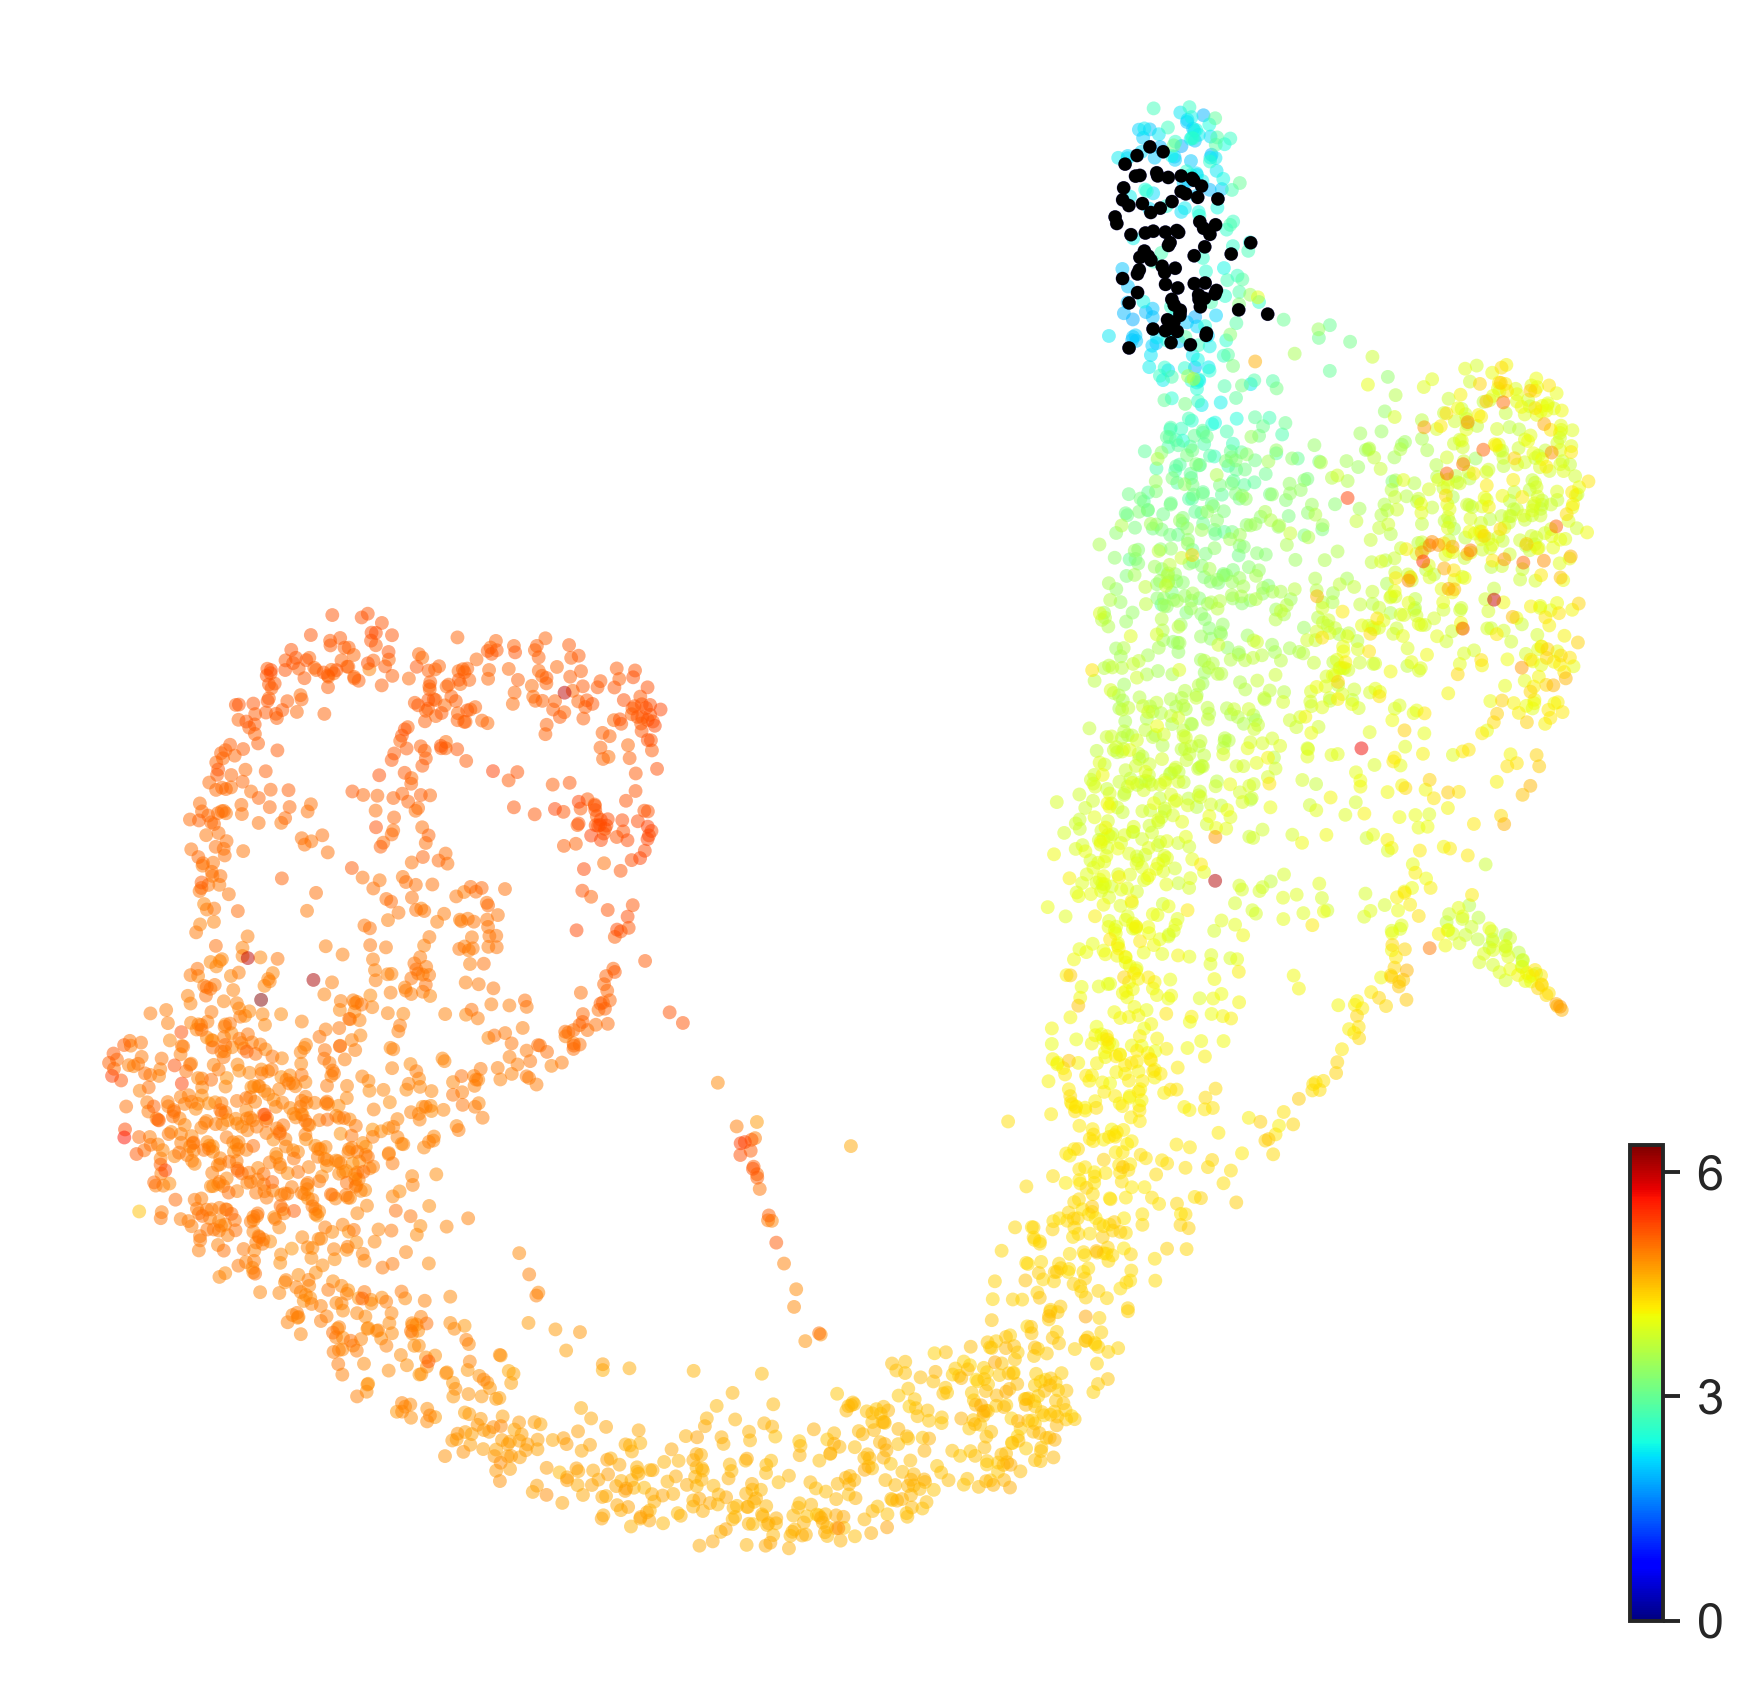

In [37]:
mb.pl.ctrp(adata, basis = 'umap')

In [38]:
df = adata.obs[['clusters','ctrp']].pivot(columns='clusters')
df.columns = df.columns.droplevel(0)
sorting =df.mean().sort_values(ascending = False).index.values

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

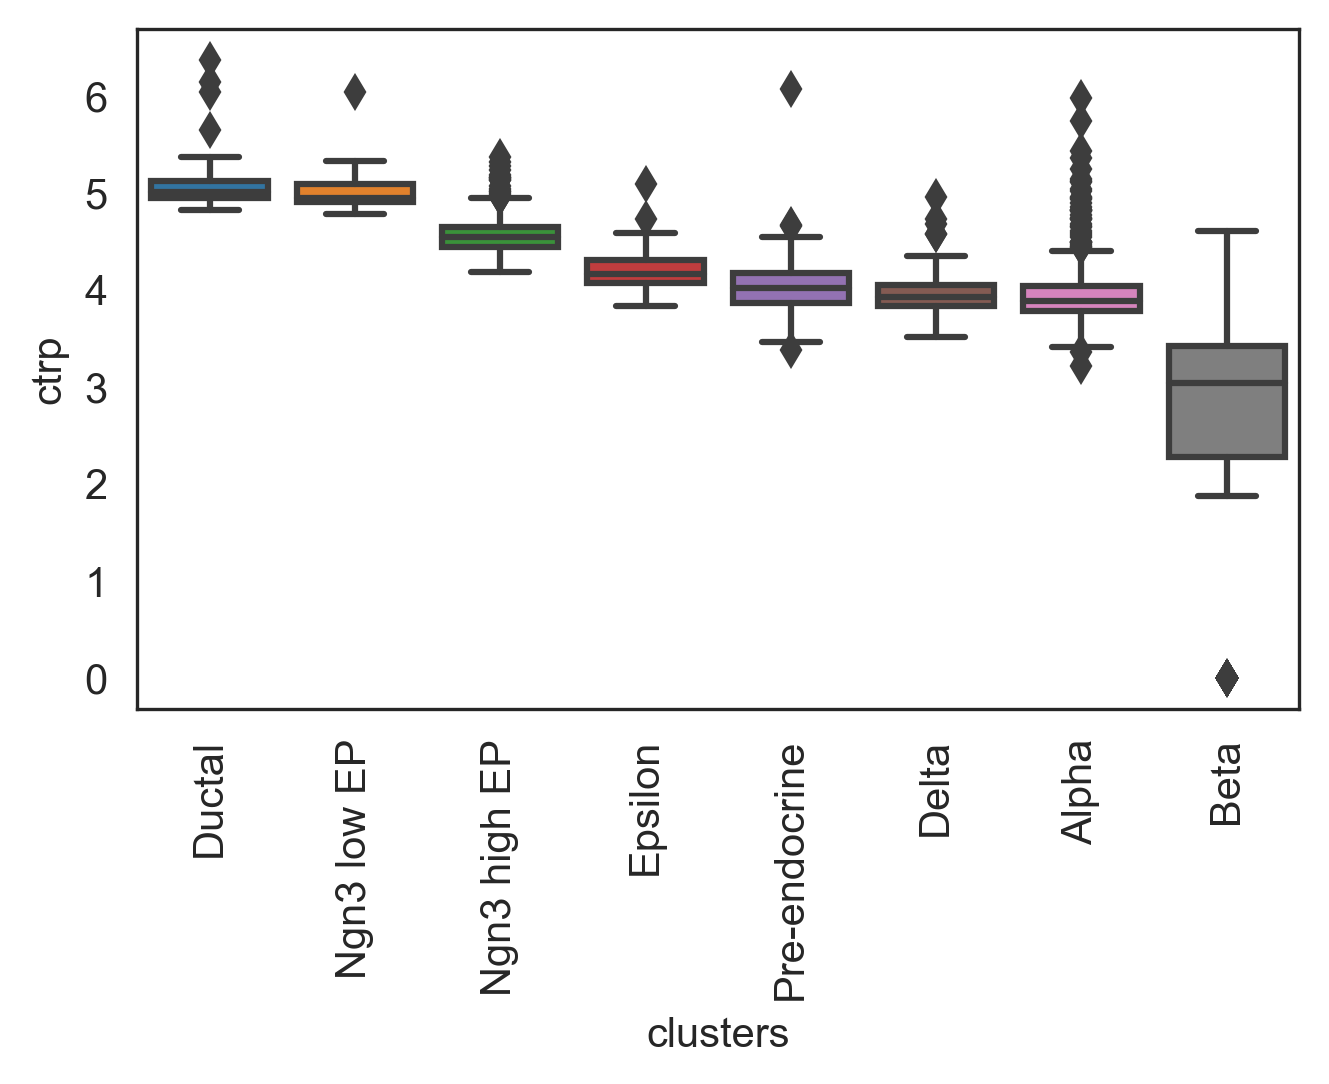

In [39]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
plt.figure(figsize=(5,3))

sns.boxplot(data = adata.obs, x = 'clusters',y='ctrp', order=sorting)
plt.xticks(rotation = 90)

In [41]:
import plotly.graph_objects as go
from scvelo.preprocessing.neighbors import get_connectivities
sankey = {}
sankey_prob = {}
_adata = adata
connectivities = get_connectivities(_adata, 'distances')
c = 'all'
T = scv.tl.transition_matrix(_adata, vkey='velocity', basis=None,  weight_diffusion=0, scale_diffusion=1,
                             self_transitions=True, backward=False)
T = T.todense()
#Calcuate N, the fundamental matrix
Q, ends = mb.ps.extract_Q(T, connectivities = connectivities, eigen=True,eps = 1e-2)
t_ind,r_ind = mb.ps.return_t_r_indices(T, connectivities = connectivities,eigen = True, eps = 1e-2)
R = T[t_ind.reshape(-1, 1), r_ind]
N = mb.ps.compute_N(Q)
p_absorbing = N.dot(R)
P_abs_df = pd.DataFrame(p_absorbing, columns = _adata.obs.iloc[r_ind].index, index = _adata.obs.iloc[t_ind].index)
P_abs_df['A'] = P_abs_df.index
P_abs_df['Source_subtype'] = [_adata.obs.loc[i]['clusters'] for i in P_abs_df.index]
P_df = pd.melt(P_abs_df, id_vars=['A','Source_subtype'],value_vars=_adata.obs.iloc[r_ind].index)
P_df.columns = ['A','Source_subtype','B','value']
P_df['sink_subtype'] = [_adata.obs.loc[i]['clusters'] for i in P_df['B']]
sankey_prob[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()/P_df.groupby(['Source_subtype']).sum()
print(P_df.head())

sankey[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()


Eigenvalues:  [0.99999946 0.9976367 ]
    identified 2 end points
                  A Source_subtype                 B     value sink_subtype
0  AAACCTGAGAGGGATA  Pre-endocrine  AAACGGGGTACAGTTC  0.004206         Beta
1  AAACCTGAGCCTTGAT         Ductal  AAACGGGGTACAGTTC  0.004256         Beta
2  AAACCTGAGGCAATTA          Alpha  AAACGGGGTACAGTTC  0.004550         Beta
3  AAACCTGCATCATCCC         Ductal  AAACGGGGTACAGTTC  0.004256         Beta
4  AAACCTGGTAAGTGGC   Ngn3 high EP  AAACGGGGTACAGTTC  0.004255         Beta


In [42]:
sankey_prob[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()/P_df.groupby(['Source_subtype']).sum()


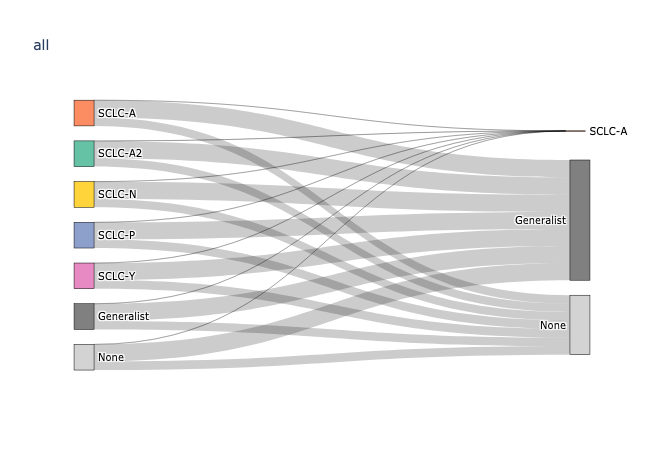

In [24]:

custom_palette = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3','grey','lightgrey','#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3','grey','lightgrey']

subtypes = ["SCLC-A", "SCLC-A2", "SCLC-N", "SCLC-P", "SCLC-Y", "Generalist",'None']
source_nodes = {}
for i,s in enumerate(subtypes):
    source_nodes[s] = i
sink_nodes = {}
for i,s in enumerate(subtypes):
    sink_nodes[s] = i + 7
    

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["SCLC-A", "SCLC-A2", "SCLC-N", "SCLC-P", "SCLC-Y", "Generalist",'None',"SCLC-A", "SCLC-A2", "SCLC-N", "SCLC-P", "SCLC-Y", "Generalist",'None'],
      color = custom_palette
    ),
    link = dict(
      source = [source_nodes[i[0]] for i in sankey_prob[c].index], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [sink_nodes[i[1]] for i in sankey_prob[c].index],
      value = sankey_prob[c]['value'].values
  ))])

fig.update_layout(title_text=c, font_size=10)
fig.show()

In [45]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image

subtypes = list(adata.obs['clusters'].cat.categories)
G = nx.DiGraph()
G.add_nodes_from(subtypes)
G.add_weighted_edges_from([r.values for i,r in sankey_prob['all'].reset_index().iterrows()])
# cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']

# color_dict = {'SCLC-Y': cp[4], 'SCLC-A': cp[0], 'SCLC-A2': cp[1], 'SCLC-N': cp[2], 'SCLC-P': cp[3],
#               'Generalist': 'darkgray', 'None': 'lightgray'}

node_colors = []
node_size = []

for node in G.nodes():
#     node_colors.append(color_dict[node])
    node_size.append(list(adata.obs['clusters'].values).count(node))
    
edges = G.edges()
G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
# colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight']*4 for u,v in edges]
pos=nx.circular_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
# fig = plt.figure(figsize = (6,6))
# nx.draw_networkx(G,pos, width = weights, node_color = node_colors, node_size = node_size, \
#                  connectionstyle = 'arc3')

A = to_agraph(G) 
# for node in G.nodes():
#     n = A.get_node(node)
#     n.attr['color'] = color_dict[node]
A.node_attr["fontsize"] = "8"
A.edge_attr["fontsize"] = "8"

A.node_attr["style"] = "filled"
# A.node_attr['label'] = ''

for edge in G.edges():
    e = A.get_edge(edge[0], edge[1])
    e.attr['label'] = str(np.round(G[edge[0]][edge[1]]['weight']*100,2)) + "%"


A.layout('dot') 
A.draw("./figures/popD_networks/pancreas.pdf", prog="neato", args="-n2")


# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

# Dentate Gyrus

In [65]:
adata = scv.datasets.dentategyrus()
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 11019 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


# Dimensionality Reduction and RNA Velocity

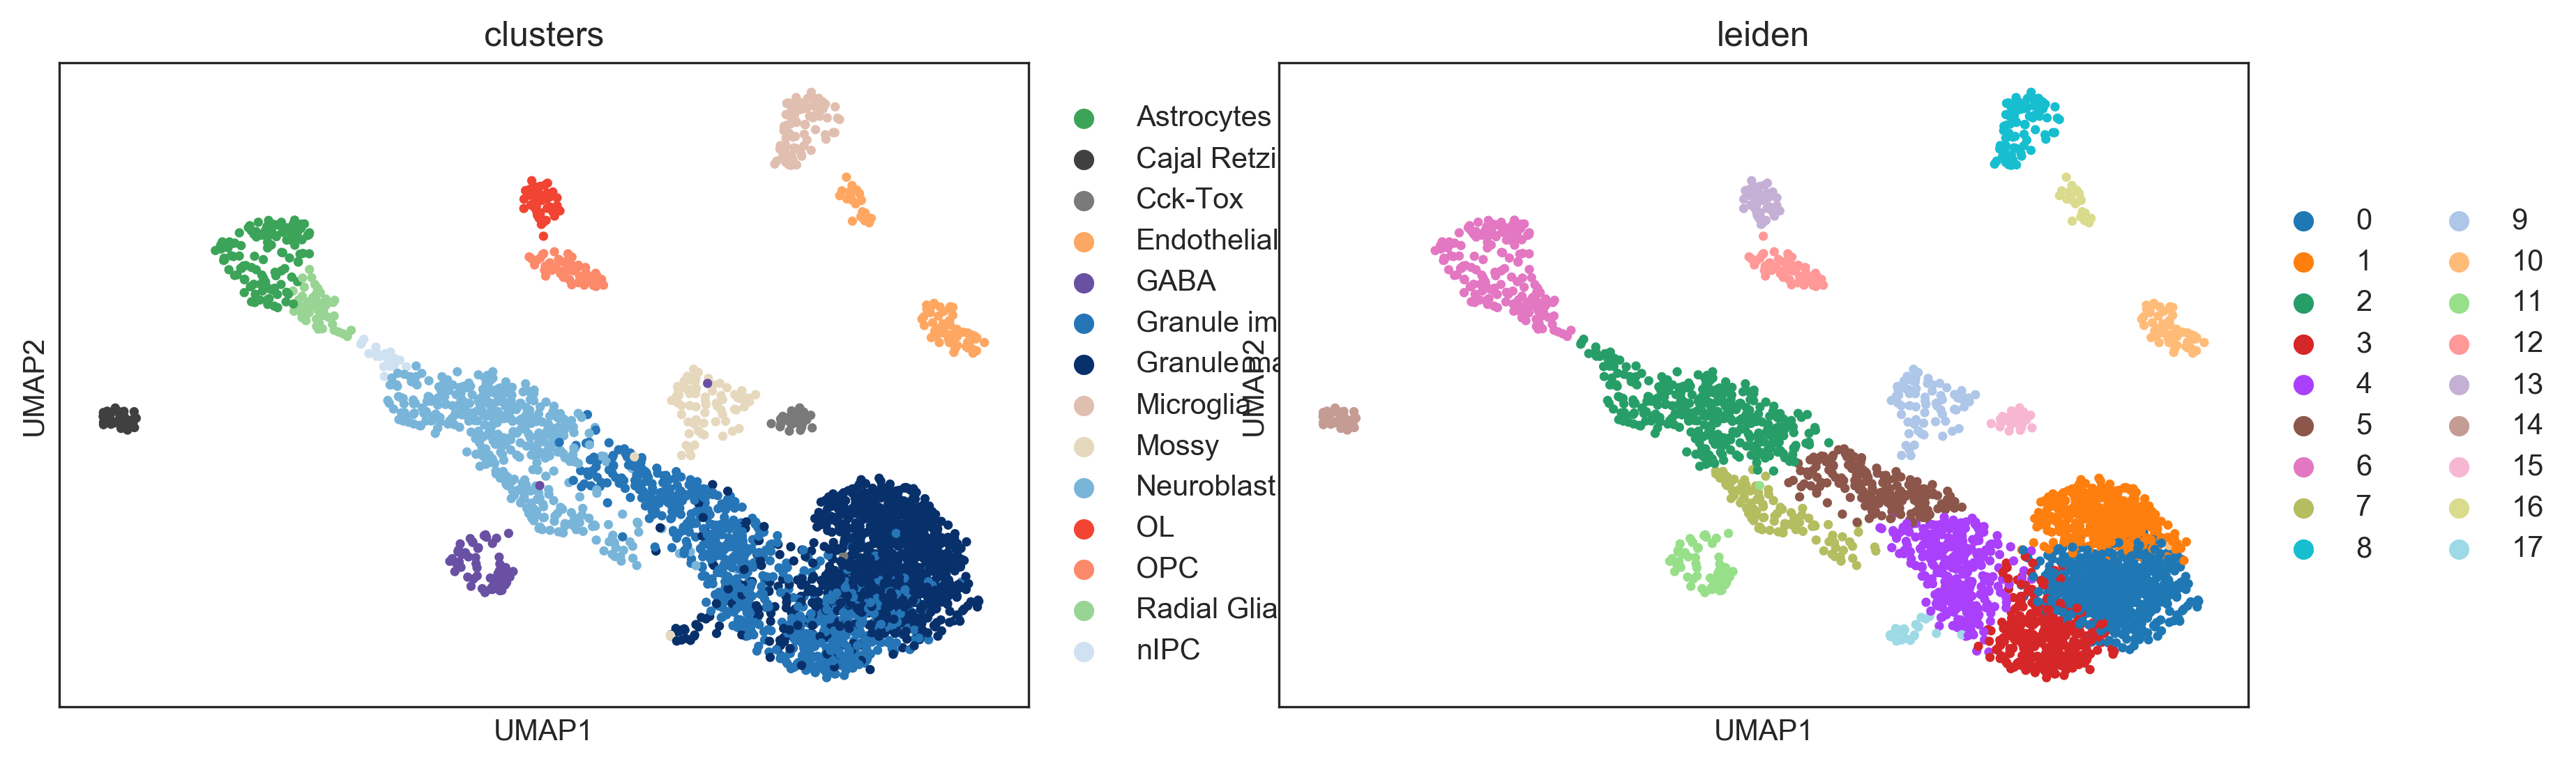

In [66]:
import matplotlib.pyplot as plt
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata, random_state = 5, min_dist = 1)
sc.pl.umap(adata, color = ['clusters','leiden'], ncols = 3)


## Calculating Velocity

In [67]:
scv.pp.moments(adata)
scv.tl.velocity(adata, mode = 'stochastic')
scv.tl.velocity_graph(adata)


computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


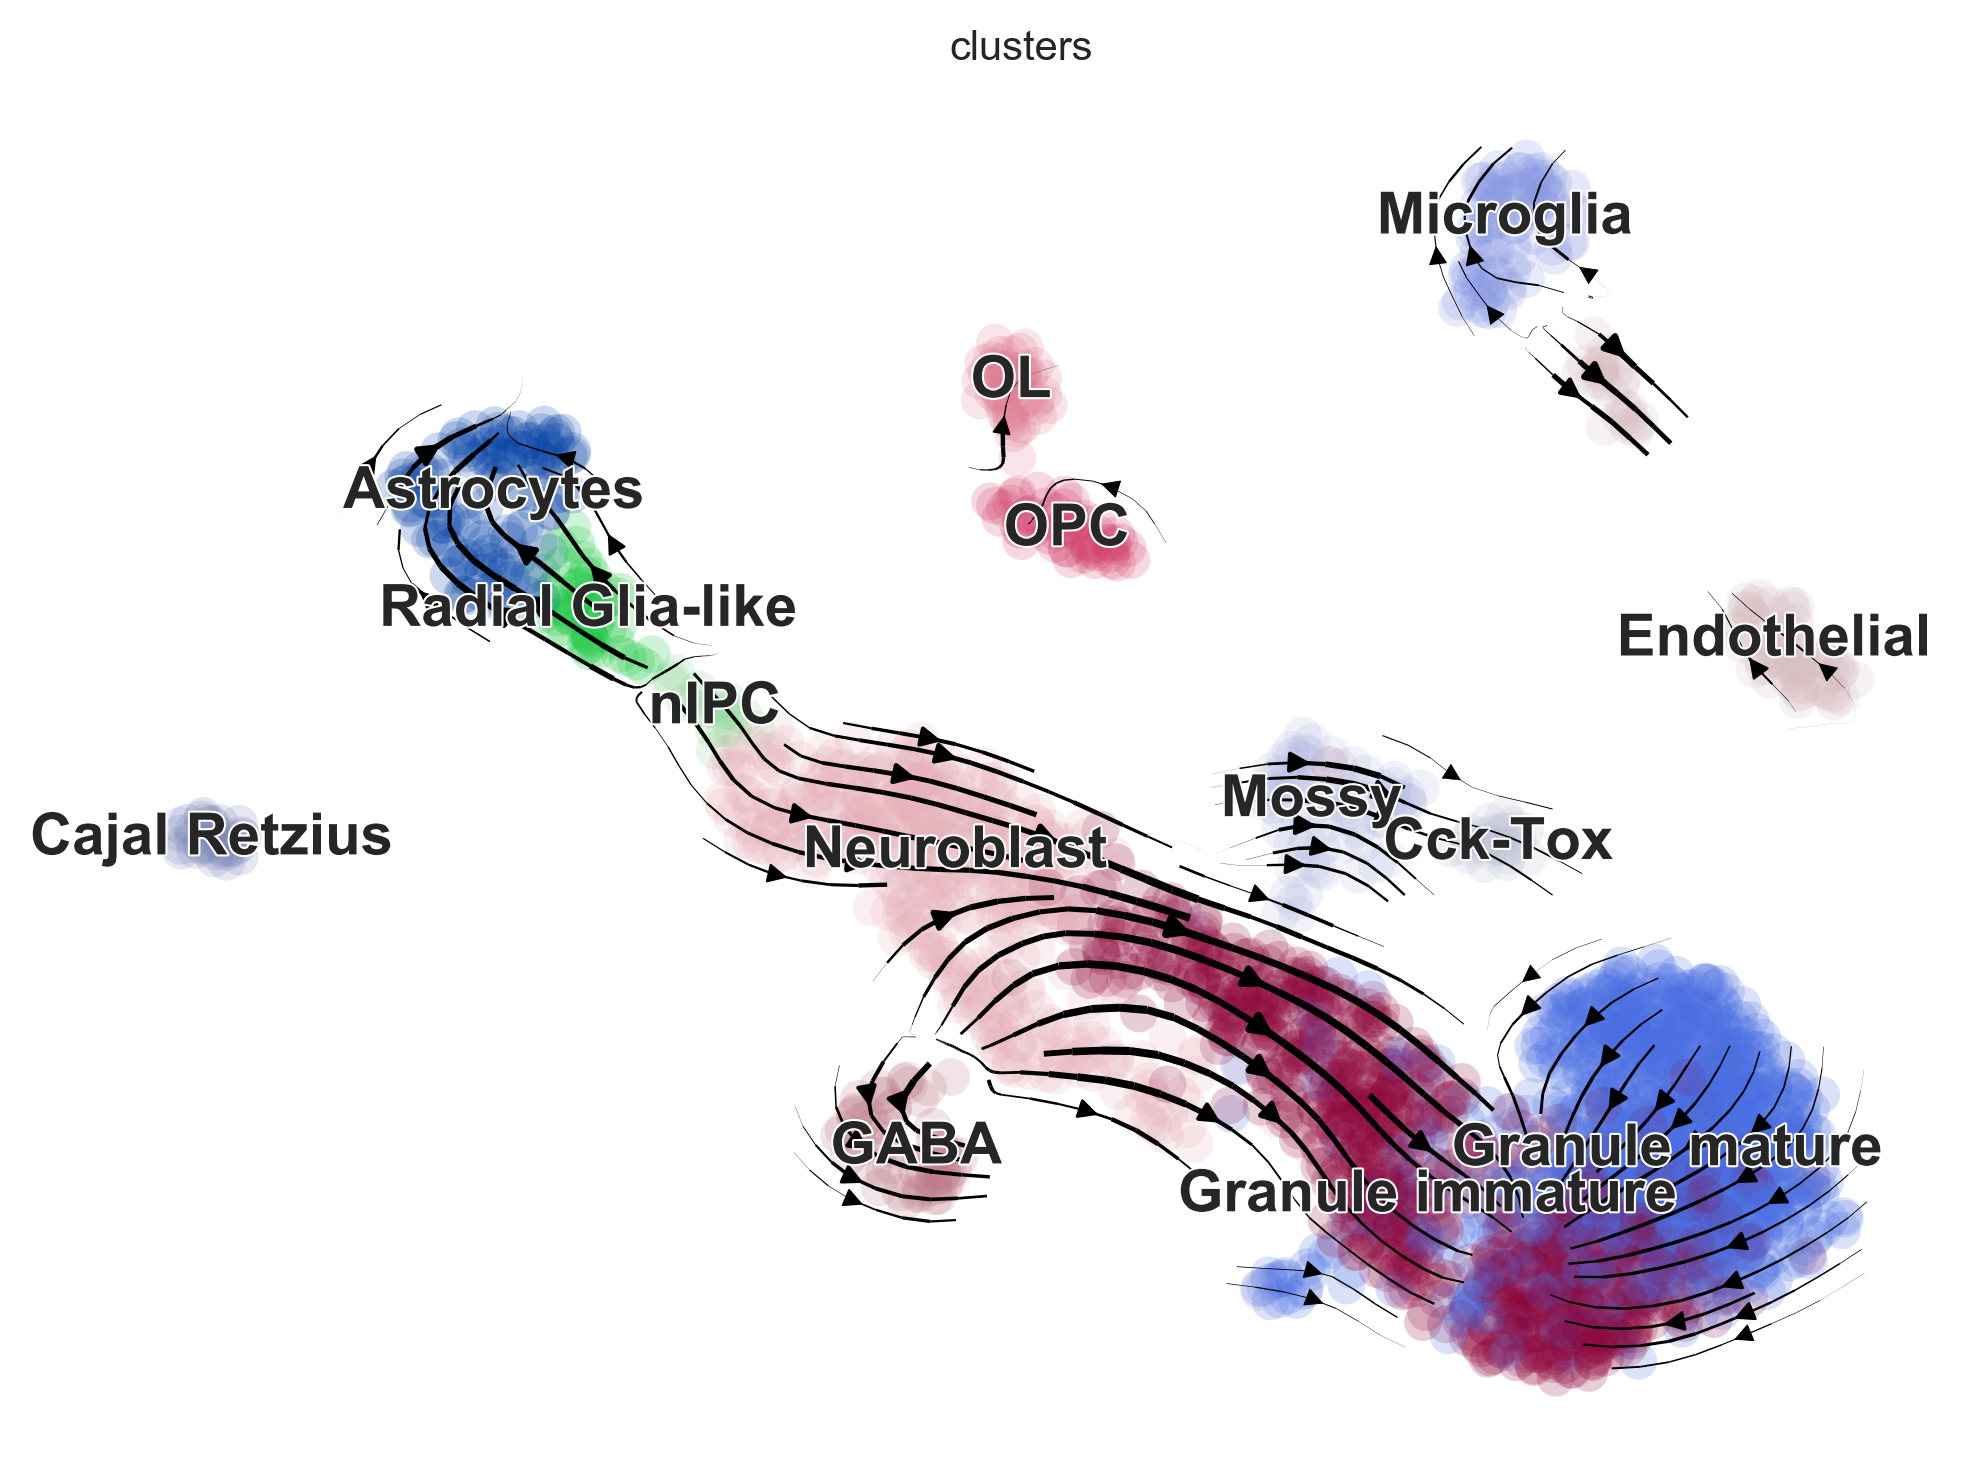

In [68]:
scv.pl.velocity_embedding_stream(adata, basis = 'umap', color = ['clusters'], legend_loc = 'on data',
                               figsize = (8,6), legend_fontsize=14, 
                                 dpi = 300, alpha=.2, palette='muted')


--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


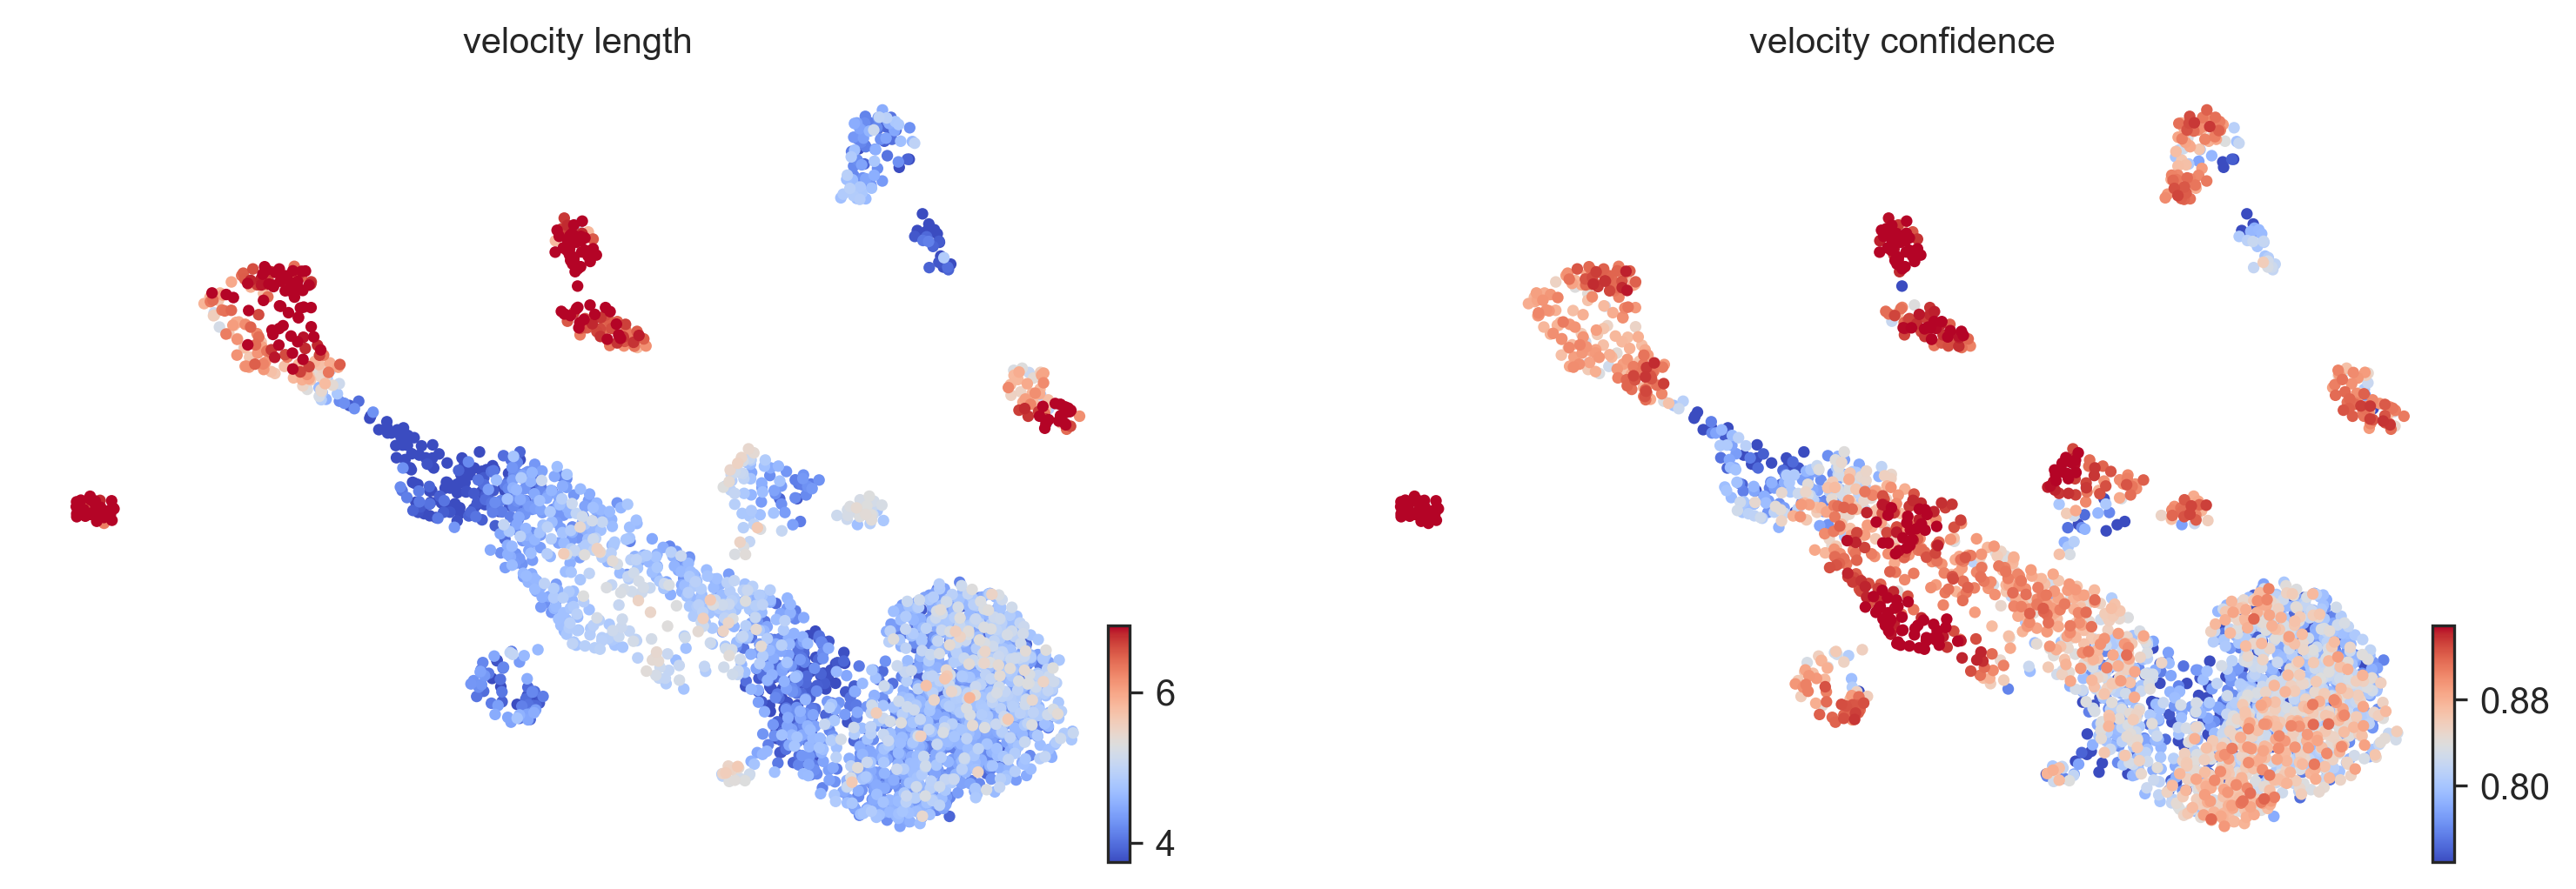

In [69]:
scv.tl.velocity_confidence(adata)

keys = 'velocity_length', 'velocity_confidence'  
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95], basis = 'umap')

# Pseudotime and plasticity

We would like to see if we can get the same results as Ireland et al. did for their pseudotime analysis. To run Monocle2, we need the R interface `rpy2`. We'll also use the pseudotime inference within scvelo for comparison.

### Velocity pseudotime

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:01) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


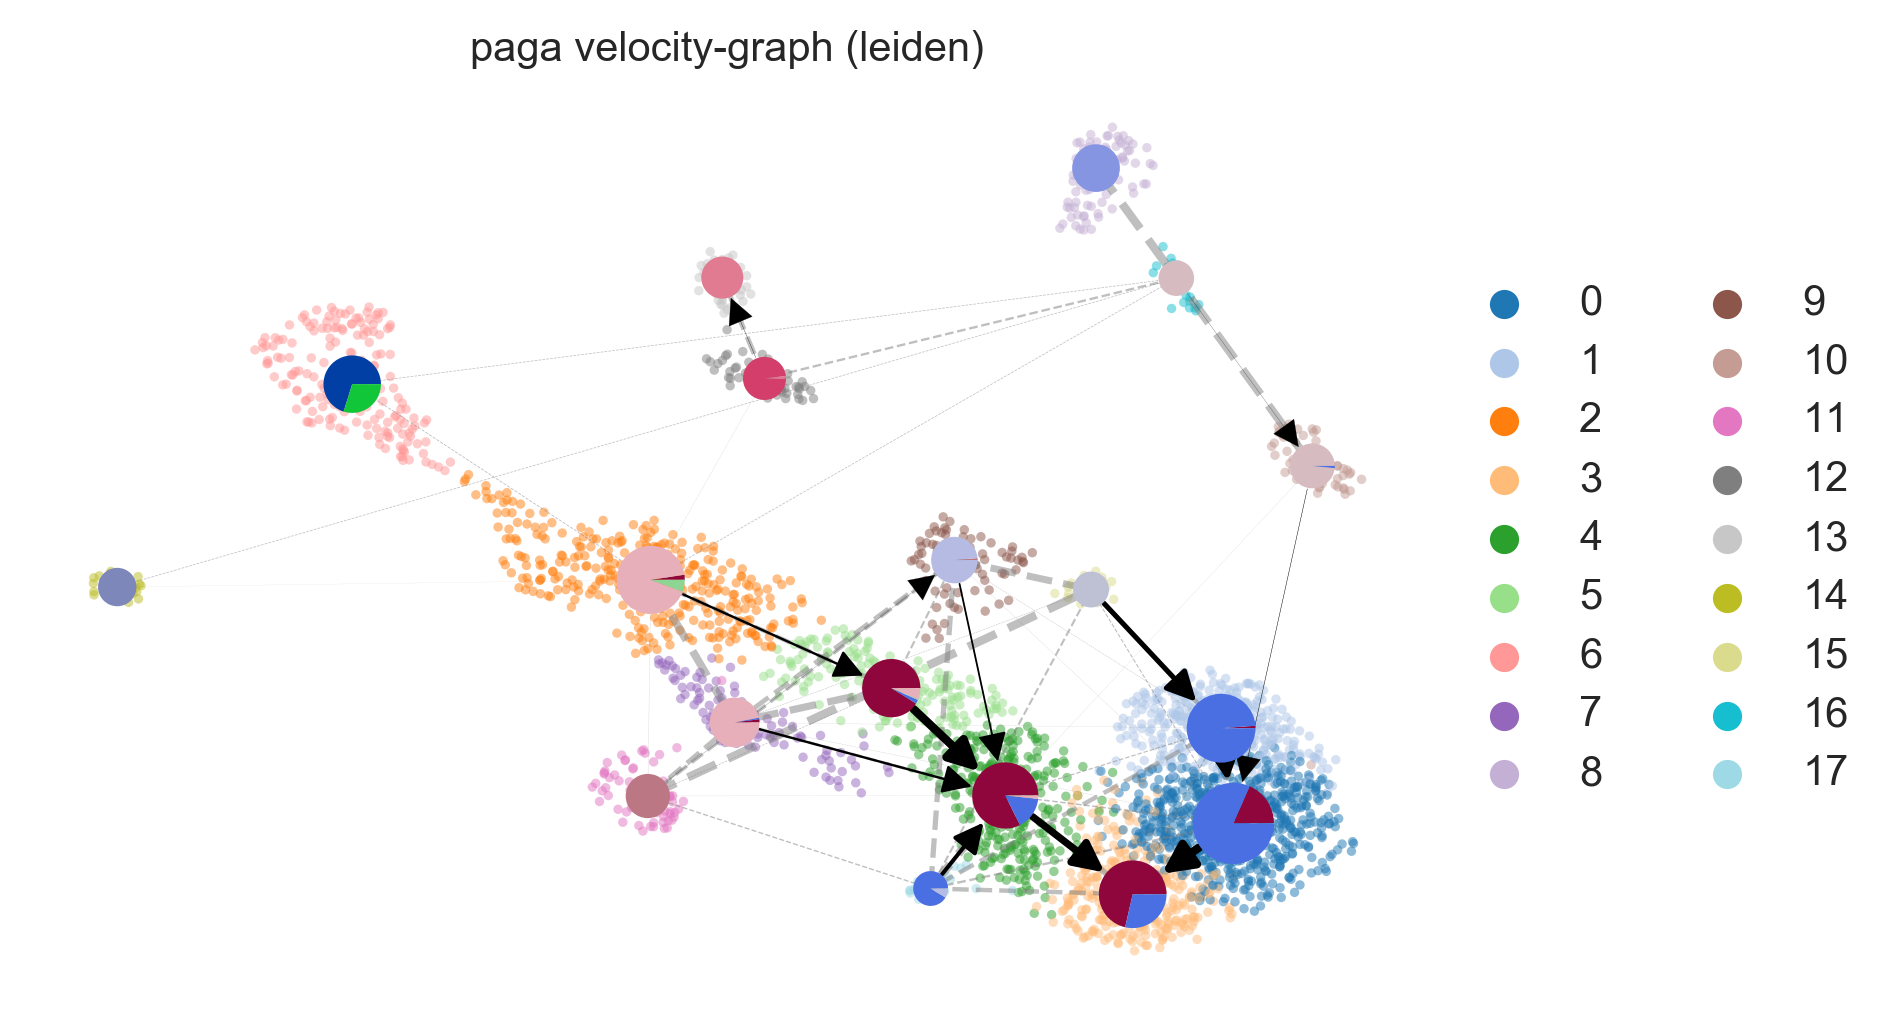

In [72]:
scv.tl.velocity_pseudotime(adata)
mb.ps.velocity_paga(adata, basis='umap', color='clusters')

In [198]:
adata.write_h5ad('../int/dentate.h5ad')

In [2]:
adata = sc.read_h5ad('../int/dentate.h5ad')

### Calculate plasticity using CTrP

In [3]:
scv.tl.terminal_states(adata)

computing terminal states
    identified 4 regions of root cells and 5 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


In [195]:
from scvelo import logging as logg
from scipy.sparse import linalg, csr_matrix, issparse
from mazebox.plasticity import  compute_N, calculate_ctrp
from scvelo import settings
from scipy.spatial import distance

from scvelo.preprocessing.moments import get_connectivities
from scvelo.preprocessing.neighbors import verify_neighbors
from scvelo.utils import scale, groups_to_bool, strings_to_categoricals, get_plasticity_score
def return_t_r_indices(P, connectivities = None, eps = 0.001, eigen = False):
    """
    :param P: transition matrix
    :param connectivities: connectivities from adata; only set if eigen == True
    :param eps: tolerance
    :param eigen: use eigenvalues to find absorbing states
    :return: [t,r]: indices of transient states and absorbing states, respectively
    """
    if eigen:
        eigvecs_ends = eigs(P, eps=1e-3, perc=[2, 98], print_val=False)[1]
        n_ends = eigvecs_ends.shape[1]
        ends = csr_matrix.dot(connectivities, eigvecs_ends).sum(1)
        ends = scale(np.clip(ends, 0, np.percentile(ends, 98)))

        indices_without_1_in_diagonal = np.where(ends < 1. - eps)[0]
        indices_with_1_in_diagonal = np.where(ends >= 1. - eps)[0]
    else:
        indices_without_1_in_diagonal = np.where(P.diagonal() < 1 - eps)[0]
        indices_with_1_in_diagonal = np.where(P.diagonal() >= 1 - eps)[0]

    return indices_without_1_in_diagonal,indices_with_1_in_diagonal

def extract_Q(P, connectivities = None, eps = 0.001, eigen = False):
    """
    For an absorbing Markov chain with transition rate matrix P this computes the
    matrix Q.

    Note that this does not assume that P is in the required format. It
    identifies the rows and columns that have a 1 in the diagonal and removes
    them.
    """
    if eigen:
        eigvecs_ends = eigs(P, eps=1e-3, perc=[2, 98])[1]
        n_ends = eigvecs_ends.shape[1]
        logg.info('    identified ' + str(n_ends) + ' end points')
        ends = csr_matrix.dot(connectivities, eigvecs_ends).sum(1)

        ends = scale(np.clip(ends, 0, np.percentile(ends, 98)))

        indices_without_1_in_diagonal = np.where(ends < 1. - eps)[0]
        Q = P[indices_without_1_in_diagonal.reshape(-1, 1), indices_without_1_in_diagonal]
        return Q, ends
    else:
        indices_without_1_in_diagonal = np.where(P.diagonal() < 1 - eps)[0]
        Q = P[indices_without_1_in_diagonal.reshape(-1, 1), indices_without_1_in_diagonal]
        return Q

    
def terminal_states(
    data,
    vkey="velocity",
    modality="Ms",
    groupby=None,
    groups=None,
    self_transitions=False,
    eps=1e-3,
    random_state=0,
    copy=False,
    **kwargs,
):
  
    adata = data.copy() if copy else data
#     verify_neighbors(adata)

    logg.info("computing terminal states", r=True)

    strings_to_categoricals(adata)
    if groupby is not None:
        logg.warn(
            "Only set groupby, when you have evident distinct clusters/lineages,"
            " each with an own root and end point."
        )

    kwargs.update({"self_transitions": self_transitions})
    categories = [None]
    if groupby is not None and groups is None:
        categories = adata.obs[groupby].cat.categories
    for cat in categories:
        groups = cat if cat is not None else groups
        cell_subset = groups_to_bool(adata, groups=groups, groupby=groupby)
        _adata = adata if groups is None else adata[cell_subset]
        connectivities = get_connectivities(_adata, "distances")

#         T = sc.tl.transition_matrix(_adata, vkey=vkey, backward=True, **kwargs)
#         eigvecs_roots = eigs(T, eps=eps, perc=[2, 98], random_state=random_state)[1]
#         roots = csr_matrix.dot(connectivities, eigvecs_roots).sum(1)
#         roots = scale(np.clip(roots, 0, np.percentile(roots, 98)))
#         roots = verify_roots(_adata, roots, modality)
#         write_to_obs(adata, "root_cells", roots, cell_subset)

#         T = scv.tl.transition_matrix(_adata, vkey=vkey, backward=False, **kwargs)
#         eigvecs_ends = eigs(T, eps=eps, perc=[2, 98], random_state=random_state)[1]
#         ends = csr_matrix.dot(connectivities, eigvecs_ends).sum(1)
#         ends = scale(np.clip(ends, 0, np.percentile(ends, 98)))
#         write_to_obs(adata, "end_points", ends, cell_subset)
            
#         n_ends = ends.shape[1]
#         groups_str = f" ({groups})" if isinstance(groups, str) else ""
#         ends_str = f"{n_ends} {'regions' if n_ends > 1 else 'region'}"

#         logg.info(
#             f"and {ends_str} of end points {groups_str}."
#         )

#     logg.info("    finished", time=True, end=" " if settings.verbosity > 2 else "\n")
#     logg.hint(
#         "added\n"
#         "    'root_cells', root cells of Markov diffusion process (adata.obs)\n"
#         "    'end_points', end points of Markov diffusion process (adata.obs)"
#     )
    
        T = scv.tl.transition_matrix(_adata, vkey=vkey, basis=None, weight_diffusion=0,
                              scale_diffusion=1, self_transitions=False, backward=False)
        print('(' + groups + ')' if isinstance(groups, str) else '')
        T = T.todense()
        #Calcuate N, the fundamental matrix
        Q, ends = extract_Q(T, connectivities = connectivities, eigen=True,eps = eps)
        t_ind,r_ind = return_t_r_indices(T, connectivities = connectivities,eigen = True, eps = eps)
        R = T[t_ind.reshape(-1, 1), r_ind]
        N = compute_N(Q)

        write_to_obs(adata, 'end_points', ends, cell_subset)
   
        _adata.obs['col'] = ends
        # Calculate the distance matrix on the transient states

        adataX = _adata.obsm['X_pca']
        D = distance.cdist(adataX, adataX, 'euclidean')
        D = D[t_ind.reshape(-1, 1), t_ind]
        ctrp = calculate_ctrp(N, D)
        p_absorbing = N.dot(R)
        print(p_absorbing)
        if cell_subset is not None:
            cs = cell_subset.copy()
            new_subset = pd.Series(cs, index = adata.obs_names.values)
            true_subset = np.where(cs == True)[0]
            for i in list(r_ind):
                new_subset.iloc[true_subset[i]] = False
        else:
            new_subset = pd.Series([True]*len(adata.obs_names.values), index = adata.obs_names.values)
            for i in list(r_ind):
                new_subset.iloc[i] = False
            if 'ctrp' in adata.obs.keys():
                adata.obs['ctrp'] = np.zeros(adata.n_obs)
        write_to_obs(adata, 'ctrp', np.log1p(ctrp), new_subset)

    adata.obs['absorbing'] = [i for i in adata.obs['end_points'] >=1. - eps]
    return adata if copy else None

# def eigs(T, k=10, eps=1e-3, perc=None, random_state=None, v0=None):
#     if random_state is not None:
#         np.random.seed(random_state)
#         v0 = np.random.rand(min(T.shape))
#     try:
#         # find k eigs with largest real part, and sort in descending order of eigenvals
#         eigvals, eigvecs = linalg.eigs(T.T, k=k, which="LR", v0=v0)
#         p = np.argsort(eigvals)[::-1]
#         eigvals = eigvals.real[p]
#         eigvecs = eigvecs.real[:, p]

#         # select eigenvectors with eigenvalue of 1 - eps.
#         idx = eigvals >= 1 - eps
#         eigvals = eigvals[idx]
#         eigvecs = np.absolute(eigvecs[:, idx])

#         if perc is not None:
#             lbs, ubs = np.percentile(eigvecs, perc, axis=0)
#             eigvecs[eigvecs < lbs] = 0
#             eigvecs = np.clip(eigvecs, 0, ubs)
#             eigvecs /= eigvecs.max(0)

#     except:
#         eigvals, eigvecs = np.empty(0), np.zeros(shape=(T.shape[0], 0))

#     return eigvals, eigvecs

def eigs(T, k=100, eps=1e-3, perc=None, print_val = True):
    try:
        eigvals, eigvecs = linalg.eigs(T.T, k=k, which='LR',  v0 = T[0])  # find k eigs with largest real part

        p = np.argsort(eigvals)[::-1]                        # sort in descending order of eigenvalues
        eigvals = eigvals.real[p]
        eigvecs = eigvecs.real[:, p]

        idx = (eigvals >= 1 - eps)                           # select eigenvectors with eigenvalue of 1 within eps tolerance
        eigvals = eigvals[idx]
        eigvecs = np.absolute(eigvecs[:, idx])
        if print_val:
            print("Eigenvalues: ", eigvals)
            # print(eigvecs.shape)
        if perc is not None:
            lbs, ubs = np.percentile(eigvecs, perc, axis=0)
            eigvecs[eigvecs < lbs] = 0
            eigvecs = np.clip(eigvecs, 0, ubs)
            eigvecs /= eigvecs.max(0)

    except:
        eigvals, eigvecs = np.empty(0), np.zeros(shape=(T.shape[0], 0))
    return eigvals, eigvecs


def write_to_obs(adata, key, vals, cell_subset=None):
    if cell_subset is None:
        adata.obs[key] = vals
    else:
        vals_all = (
            adata.obs[key].copy() if key in adata.obs.keys() else np.zeros(adata.n_obs)
        )
        vals_all[cell_subset] = vals
        adata.obs[key] = vals_all


In [196]:
terminal_states(adata, eps = .1)

computing terminal states

Eigenvalues:  [0.99999994 0.999976   0.9998673  0.99983793 0.9993404 ]
    identified 5 end points
[[3.46172721e-04 5.89859222e-05 4.46087665e-05 ... 1.63611540e-04
  2.99805109e-04 2.16191109e-04]
 [2.37624147e-02 4.38424639e-03 2.56612667e-20 ... 4.69207700e-03
  1.42263611e-02 4.77028445e-03]
 [1.19324574e-02 2.03986234e-03 3.56947533e-15 ... 5.61876228e-03
  1.03136452e-02 7.41479352e-03]
 ...
 [1.19647966e-02 2.03871844e-03 1.14268622e-11 ... 5.65480922e-03
  1.03624441e-02 7.47267358e-03]
 [3.24566737e-02 3.73708924e-03 2.93955626e-20 ... 3.71232533e-03
  2.17794510e-02 3.73037547e-03]
 [4.20315226e-04 7.16193440e-05 5.23146488e-02 ... 1.98654075e-04
  3.64018087e-04 2.62497011e-04]]


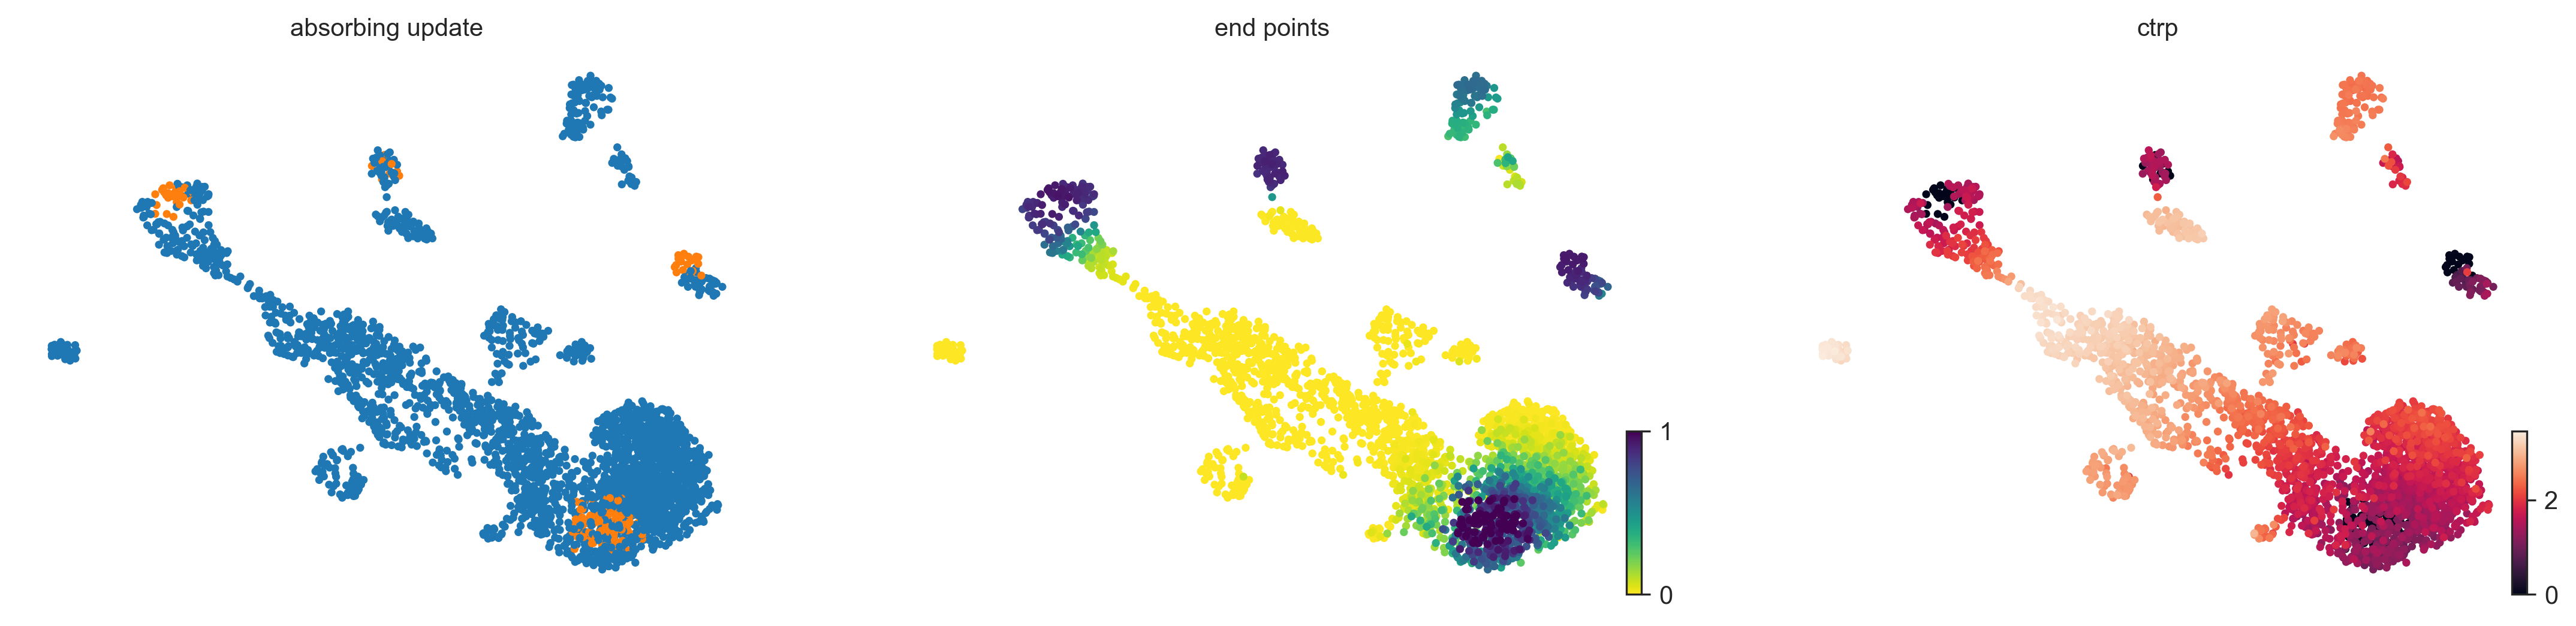

In [197]:
adata.obs['absorbing_update'] = [i for i in adata.obs['end_points'] >=1. - 0.1]
scv.pl.umap(adata, color = ['absorbing_update','end_points', 'ctrp'])

In [8]:
mb.ps.ctrp_simplified(adata, distance_basis='X_pca', self_transitions=False, eps=.1)


Eigenvalues:  [0.99999994 0.999976   0.9998673  0.99983793 0.9993404 ]
    identified 5 end points
[[3.46172721e-04 5.89859222e-05 4.46087665e-05 ... 1.63611540e-04
  2.99805109e-04 2.16191109e-04]
 [2.37624147e-02 4.38424639e-03 2.56612667e-20 ... 4.69207700e-03
  1.42263611e-02 4.77028445e-03]
 [1.19324574e-02 2.03986234e-03 3.56947533e-15 ... 5.61876228e-03
  1.03136452e-02 7.41479352e-03]
 ...
 [1.19647966e-02 2.03871844e-03 1.14268622e-11 ... 5.65480922e-03
  1.03624441e-02 7.47267358e-03]
 [3.24566737e-02 3.73708924e-03 2.93955626e-20 ... 3.71232533e-03
  2.17794510e-02 3.73037547e-03]
 [4.20315226e-04 7.16193440e-05 5.23146488e-02 ... 1.98654075e-04
  3.64018087e-04 2.62497011e-04]]


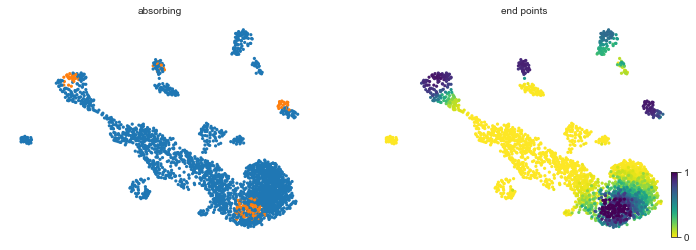

In [10]:

scv.pl.umap(adata, color = ['absorbing','end_points'])

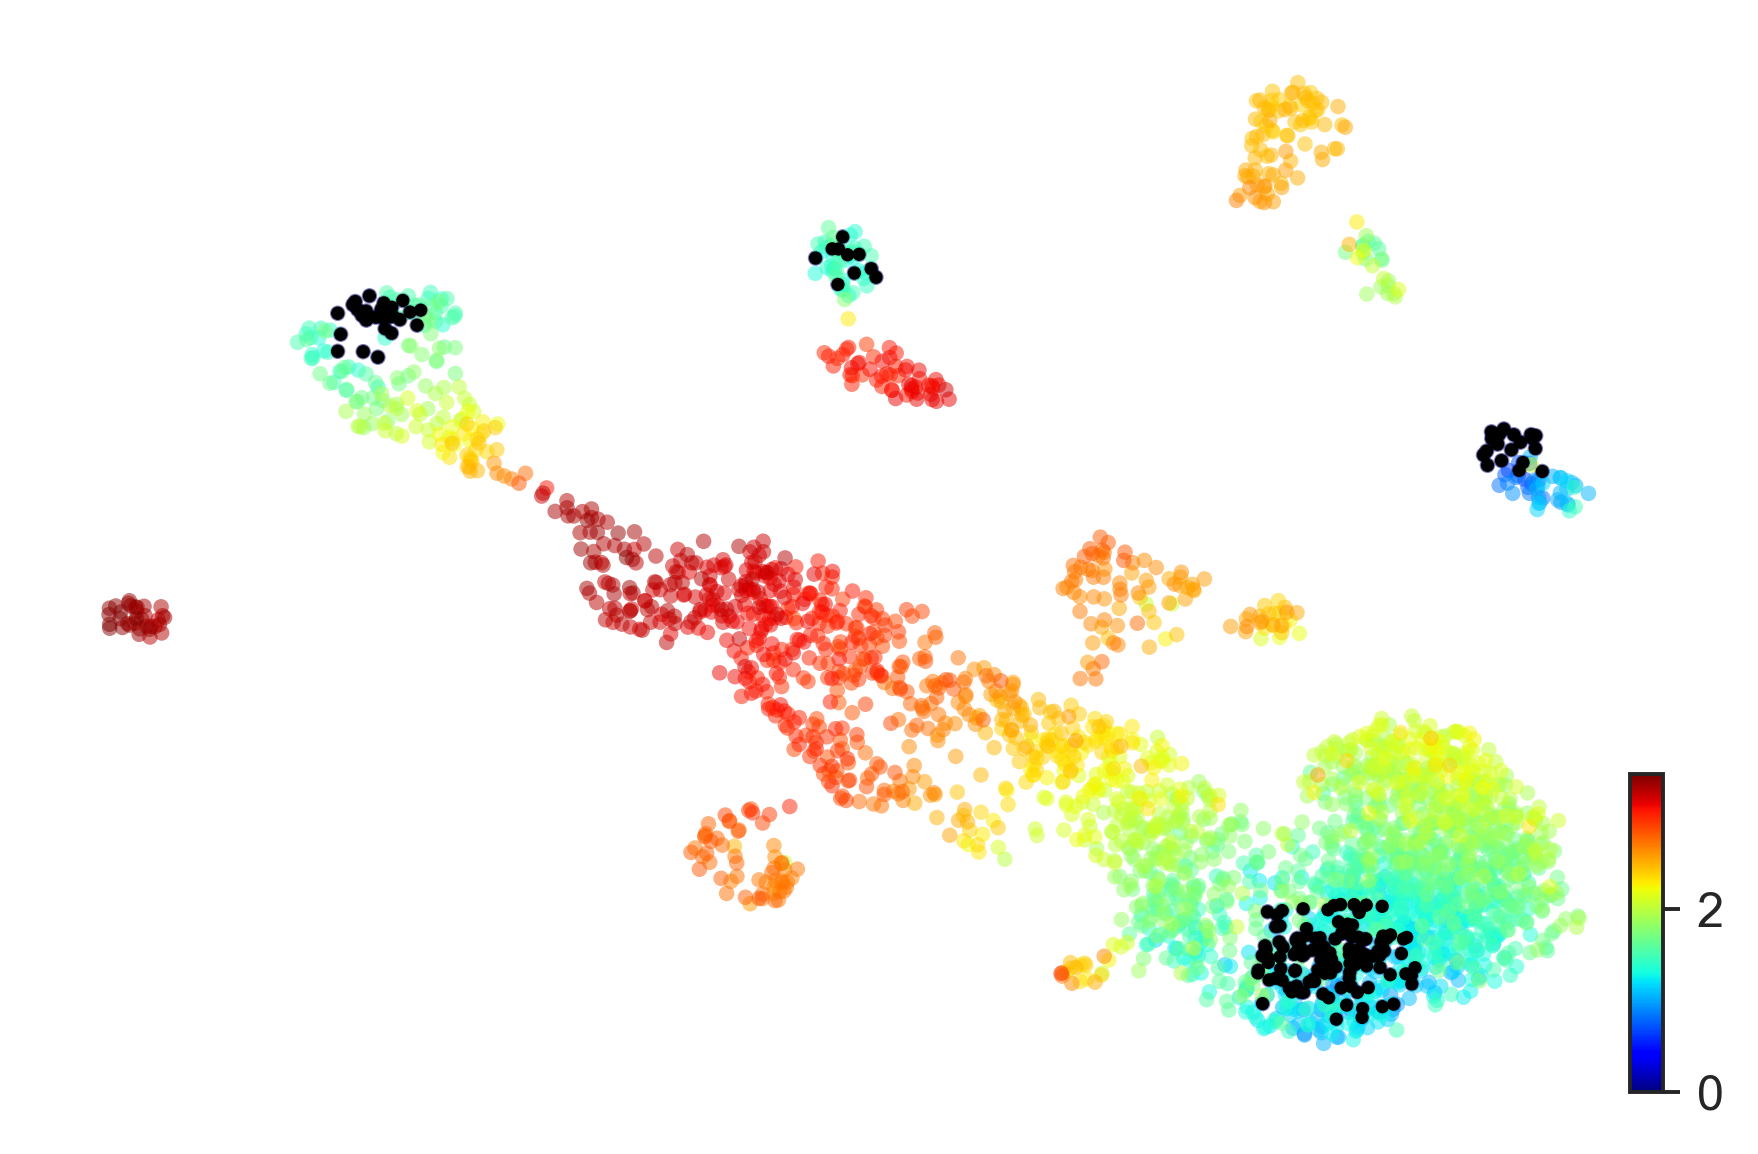

In [9]:
mb.pl.ctrp(adata, basis = 'umap', figsize=(6,4))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'Astrocytes'),
  Text(1, 0, 'Radial Glia-like'),
  Text(2, 0, 'OPC'),
  Text(3, 0, 'Endothelial'),
  Text(4, 0, 'nIPC'),
  Text(5, 0, 'GABA'),
  Text(6, 0, 'Mossy'),
  Text(7, 0, 'Cajal Retzius'),
  Text(8, 0, 'Neuroblast'),
  Text(9, 0, 'Cck-Tox'),
  Text(10, 0, 'Microglia'),
  Text(11, 0, 'OL'),
  Text(12, 0, 'Granule immature'),
  Text(13, 0, 'Granule mature')])

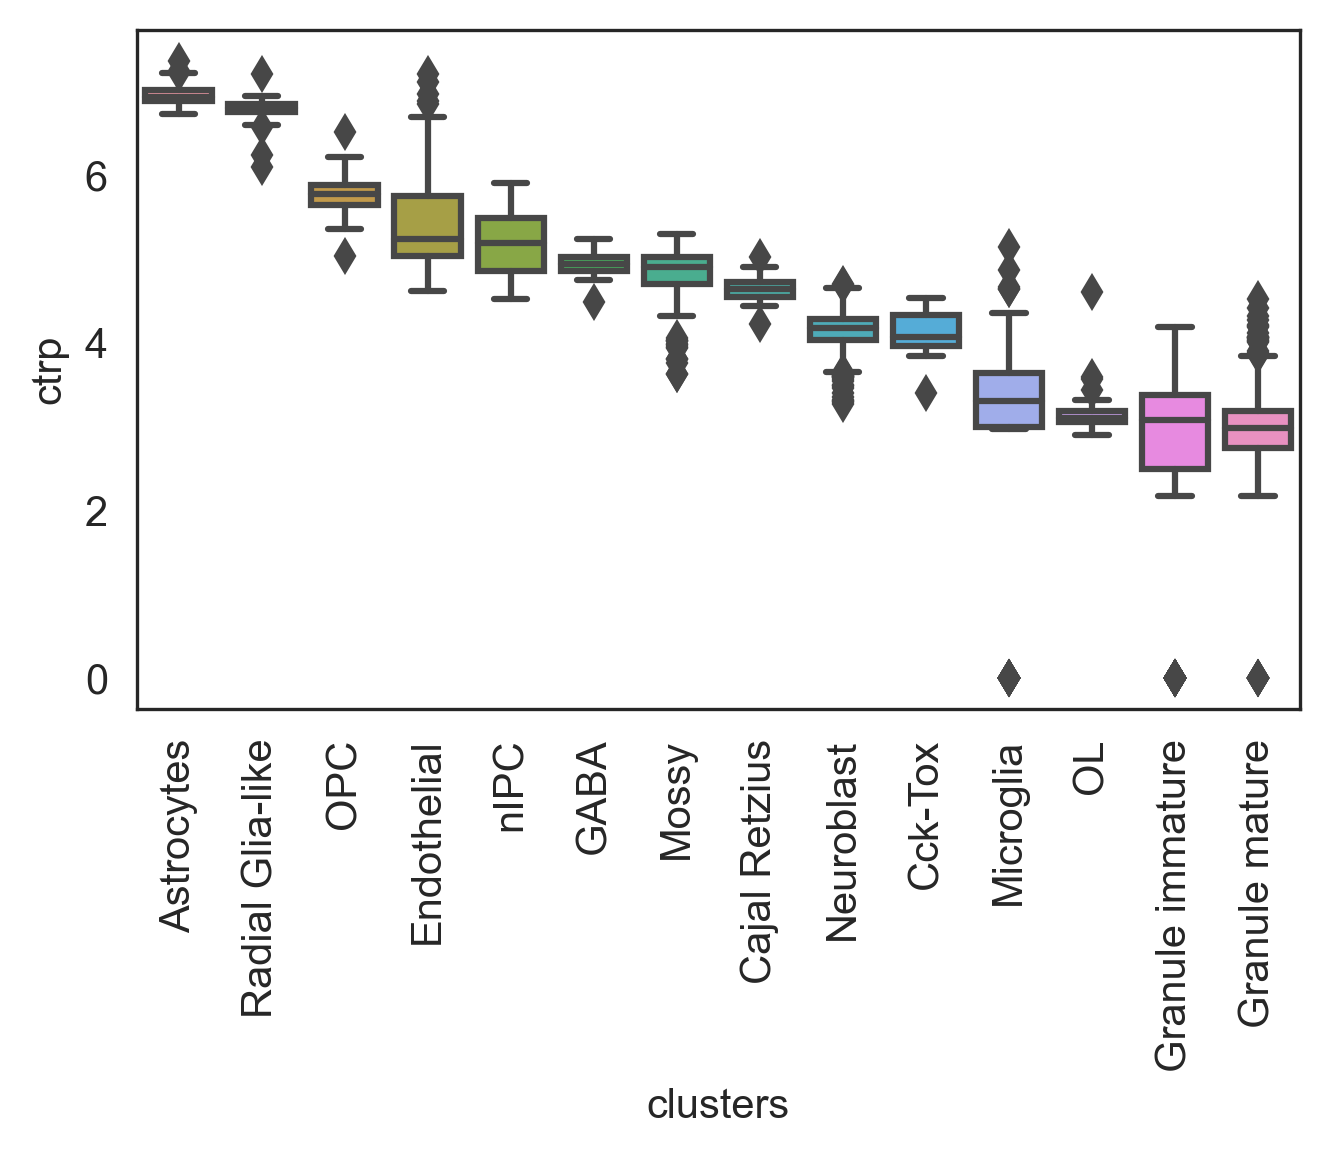

In [65]:
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
df = adata.obs[['clusters','ctrp']].pivot(columns='clusters')
df.columns = df.columns.droplevel(0)
sorting =df.median().sort_values(ascending = False).index.values
plt.figure(figsize=(5,3))

ax = sns.boxplot(data = adata.obs, x = 'clusters',y='ctrp', order=sorting)
# add_stat_annotation(ax, data=adata.obs, x='clusters',y = 'ctrp',
#                     order = sorting,
#                     box_pairs=[('Astrocytes','Radial Glia-like'),
#                               ('Radial Glia-like','OPC'), ("OPC", "Endothelial"),
#                                ("Endothelial", "nIPC")],
#                     test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
plt.xticks(rotation = 90)

In [11]:
import plotly.graph_objects as go
from scvelo.preprocessing.neighbors import get_connectivities
sankey = {}
sankey_prob = {}
_adata = adata
connectivities = get_connectivities(_adata, 'distances')
c = 'all'
T = scv.tl.transition_matrix(_adata, vkey='velocity', basis=None,  weight_diffusion=0, scale_diffusion=1,
                             self_transitions=True, backward=False)
T = T.todense()
#Calcuate N, the fundamental matrix
Q, ends = mb.ps.extract_Q(T, connectivities = connectivities, eigen=True,eps = 1e-2)
t_ind,r_ind = mb.ps.return_t_r_indices(T, connectivities = connectivities,eigen = True, eps = 1e-2)
R = T[t_ind.reshape(-1, 1), r_ind]
N = mb.ps.compute_N(Q)
p_absorbing = N.dot(R)
P_abs_df = pd.DataFrame(p_absorbing, columns = _adata.obs.iloc[r_ind].index, index = _adata.obs.iloc[t_ind].index)
P_abs_df['A'] = P_abs_df.index
P_abs_df['Source_subtype'] = [_adata.obs.loc[i]['clusters'] for i in P_abs_df.index]
P_df = pd.melt(P_abs_df, id_vars=['A','Source_subtype'],value_vars=_adata.obs.iloc[r_ind].index)
P_df.columns = ['A','Source_subtype','B','value']
P_df['sink_subtype'] = [_adata.obs.loc[i]['clusters'] for i in P_df['B']]
sankey_prob[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()/P_df.groupby(['Source_subtype']).sum()
print(P_df.head())

sankey[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()


Eigenvalues:  [1.0000007  0.9999774  0.99991065 0.99986124 0.9995548 ]
    identified 5 end points
                A    Source_subtype               B     value  \
0  AAACATACCGTAGT  Radial Glia-like  AAACATACCCATGA  0.019007   
1  AAACATACGAGAGC    Granule mature  AAACATACCCATGA  0.034823   
2  AAACATACTGAGGG  Granule immature  AAACATACCCATGA  0.021320   
3  AAACATTGGCATCA  Granule immature  AAACATACCCATGA  0.038933   
4  AAACATTGTTTGTC        Neuroblast  AAACATACCCATGA  0.021380   

       sink_subtype  
0  Granule immature  
1  Granule immature  
2  Granule immature  
3  Granule immature  
4  Granule immature  


In [12]:
sankey_prob[c] = P_df.groupby(['Source_subtype','sink_subtype']).sum()/P_df.groupby(['Source_subtype']).sum()


In [13]:
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph 
from IPython.display import Image

subtypes = list(adata.obs['clusters'].cat.categories)
G = nx.DiGraph()
G.add_nodes_from(subtypes)
G.add_weighted_edges_from([r.values for i,r in sankey_prob['all'].reset_index().iterrows()])
# cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']

# color_dict = {'SCLC-Y': cp[4], 'SCLC-A': cp[0], 'SCLC-A2': cp[1], 'SCLC-N': cp[2], 'SCLC-P': cp[3],
#               'Generalist': 'darkgray', 'None': 'lightgray'}

node_colors = []
node_size = []

for node in G.nodes():
#     node_colors.append(color_dict[node])
    node_size.append(list(adata.obs['clusters'].values).count(node))
    
edges = G.edges()
G.graph['edge'] = {'arrowsize': '0.6', 'splines': 'curved'}
# colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight']*4 for u,v in edges]
pos=nx.circular_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
# fig = plt.figure(figsize = (6,6))
# nx.draw_networkx(G,pos, width = weights, node_color = node_colors, node_size = node_size, \
#                  connectionstyle = 'arc3')

A = to_agraph(G) 
# for node in G.nodes():
#     n = A.get_node(node)
#     n.attr['color'] = color_dict[node]
A.node_attr["fontsize"] = "8"
A.edge_attr["fontsize"] = "8"

A.node_attr["style"] = "filled"
# A.node_attr['label'] = ''

for edge in G.edges():
    e = A.get_edge(edge[0], edge[1])
    e.attr['label'] = str(np.round(G[edge[0]][edge[1]]['weight']*100,2)) + "%"


A.layout('dot') 
A.draw("./figures/popD_networks/dentategyrus.pdf", prog="neato", args="-n2")


# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)